In [1]:
import pandas as pd
import numpy as np
import sys
import json 
import random
import math
import collections
import seaborn as sns
import networkx as nx
#!{sys.executable} -m pip install python-igraph
#!{sys.executable} -m pip install igraph
from collections import defaultdict
from scipy.stats.stats import pearsonr

from matplotlib import pyplot as plt
#!{sys.executable} -m pip install cdlib


import cdlib
from cdlib import algorithms as cd
from cdlib import readwrite, viz, evaluation

In [2]:

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

from sklearn.metrics import silhouette_score

from sklearn import preprocessing

# Static Community Discovery
## Preparation

In [ ]:
G = nx.read_weighted_edgelist('../../data/tuscanyJ_backboned.weighted.edgelist',delimiter=',')
len(G.nodes)

In [ ]:

weights = [G.edges[edge]['weight'] for edge in G.edges()]
maxW = max(weights) 
for edge in G.edges():
     G.edges[edge]['dissimilarity'] = 10000 - G.edges[edge]['weight']
    #G.edges[edge]['dissimilarity'] =  maxW+1 - G.edges[edge]['weight']

In [ ]:
components =  [c for c in sorted(nx.connected_components(G), key=len, reverse=True)]
avg_size = np.average([len(c) for c in components[1:]])
print('average componets size: ', avg_size)
print(len(components))
print([len(c) for c in components[:20]],'etc...')

C = G.subgraph(components[0]).copy()


In [ ]:
import pandas as pd
df = pd.read_csv("../data/geotuscany.csv",index_col=0)

#for node in C.nodes():
  #  C.nodes[node]['name'] = df.loc[int(node),'name']
    
df.head()

In [13]:
for i in  df[(df.latitude.isna()) | (df.longitude.isna())].index:
    prov = df.loc[i,'province']
    df.loc[i,'latitude'] = np.mean(df.loc[(~df.latitude.isna()) & (df.province == prov),'latitude'])
    df.loc[i,'longitude'] = np.mean(df.loc[(~df.longitude.isna()) & (df.province == prov),'longitude']) 

In [14]:
df = df.loc[[int(node) for node in C.nodes]].copy()
print(len(df))

15485


In [15]:
df.reset_index(inplace=True)
index_map = {str(old):new for new,old in df['index'].items()}
G = nx.relabel_nodes(C, index_map) 
for node in G.nodes: G.nodes[node]['province'] = df.loc[node,'province']

In [16]:
df.to_csv('../data/connenctedJ.csv')
nx.write_weighted_edgelist(G,'../data/connectedJ.weighted.edgelist')

## Data Loading

In [87]:
G = nx.read_weighted_edgelist('../data/connected.weighted.edgelist')
G = nx.relabel_nodes(G, {node:int(node) for node in G.nodes}) 
df = pd.read_csv('../data/connencted.csv',index_col=0)
for node in G.nodes:
    G.nodes[node]['province'] = df.loc[node,'province']

weights = [G.edges[edge]['weight'] for edge in G.edges()]
maxW = max(weights) 
for edge in G.edges():
    #G.edges[edge]['dissimilarity'] = 10001 - G.edges[edge]['weight']
    G.edges[edge]['dissimilarity'] =  maxW+1 - G.edges[edge]['weight']
    
df.head()

FileNotFoundError: [Errno 2] No such file or directory: '../data/conn_communities.edgelist'

In [54]:
def assign(g,communities, attribute, overlap=False):
    
    if ~overlap:
        
        for label, community in enumerate(communities.communities):
            for node in community:
                g.nodes[node][attribute] = label
                
    else: 
        
        for node in g.nodes:
            g.nodes[node][attribute] = list()
            
        for label, community in enumerate(communities.communities):
            g.nodes[node][attribute].append(label)

<AxesSubplot:xlabel='longitude', ylabel='latitude'>

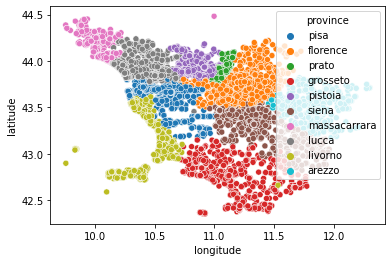

In [13]:
sns.scatterplot(data = df, x='longitude',y='latitude',hue='province')

In [14]:
provincemapping = {e:i for i,e in enumerate(df.province.unique())}

In [15]:
provinces =  {"communities":[[] for _ in df['province'].unique()]}
for i, c in df['province'].items():
    provinces['communities'][provincemapping[c]].append(i)
   
provinces["algorithm"] = 'provinces'
provinces["params"] =  {"initial_membership": None, "weights": None}
provinces["overlap"] = False
provinces["coverage"]= 1.0
with open('../data/communities/provinces.json','w+') as jf:
    json.dump(provinces, jf)


## Crisp Communities

### K means 
Use longitude and latitude

In [24]:
kmeans = KMeans(n_clusters=10, random_state=0).fit(df[['latitude','longitude']])
print(pd.Series(kmeans.labels_).value_counts())

1    3599
6    2548
2    2045
9    1712
4    1135
3    1115
0    1069
7    1055
5     759
8     448
dtype: int64


In [25]:
df['kmeans'] = kmeans.labels_.astype(str)

<AxesSubplot:xlabel='longitude', ylabel='latitude'>

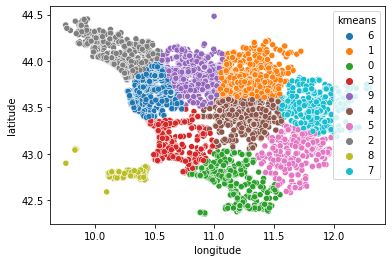

In [26]:
sns.scatterplot(data = df, x='longitude',y='latitude',hue='kmeans')

In [27]:
data = {"communities":[[] for _ in df['kmeans'].unique()]}
for i, c in df['kmeans'].items():
    data['communities'][int(c)].append(i)
  
data["algorithm"] = 'kmeans'
data["params"] =  {"initial_membership": None, "weights": None}
data["overlap"] = False
data["coverage"]= 1.0
with open('../data/communities/kmeans.json','w+') as jf:
    json.dump(data, jf)

    


In [28]:
for node in G.nodes:
    G.nodes[node]['kmeans'] = df.loc[node,'kmeans']

### Louvain

In [17]:
louvain = cd.louvain(G, resolution=1,weight='dissimilarity')
print(len(louvain.communities),[len(c) for c in louvain.communities ])


21 [2044, 1961, 1604, 1377, 1343, 1282, 950, 845, 839, 572, 558, 477, 456, 253, 139, 130, 59, 57, 44, 8, 5]


<AxesSubplot:xlabel='longitude', ylabel='latitude'>

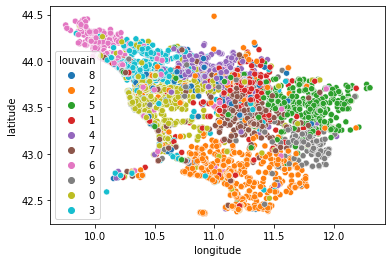

In [18]:
readwrite.write_community_json(louvain,'../data/communitiesW/louvain.json')
assign(G,louvain,'louvain')
for node in G.nodes:
    df.loc[node,'louvain'] = str(G.nodes[node]['louvain'])

sns.scatterplot(data = df[df.louvain.astype(int)<10], x='longitude',y='latitude',hue='louvain')

### multicore

In [13]:
multicore = cd.multicore(G,alfa=0.8,weight='dissimilarity',minsize = 300)

In [14]:
[len(c) for c in multicore.communities]

[4794, 3716, 3565, 2928]

<AxesSubplot:xlabel='longitude', ylabel='latitude'>

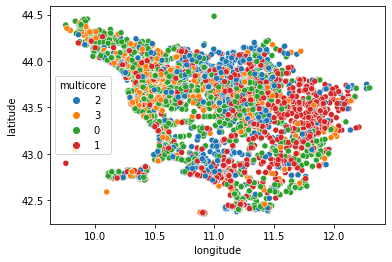

In [73]:
assign(G,multicore,'multicore')
for node in G.nodes:
    df.loc[node,'multicore'] = str(G.nodes[node]['multicore'])

sns.scatterplot(data = df[df.multicore.astype(int)<20], x='longitude',y='latitude',hue='multicore')

In [16]:
readwrite.write_community_json(multicore,'../data/communitiesW/multicore.json')

In [38]:
multicore = cd.multicore(G,alfa=0.8,weight='dissimilarity',minsize = 150,voteweight='weight')

In [39]:
[len(c) for c in multicore.communities]

[696,
 649,
 648,
 635,
 624,
 572,
 519,
 496,
 491,
 472,
 468,
 453,
 424,
 419,
 393,
 390,
 389,
 389,
 387,
 385,
 380,
 373,
 342,
 341,
 340,
 333,
 301,
 290,
 275,
 273,
 266,
 261,
 245,
 244,
 240,
 237,
 233,
 210,
 210,
 192]

<AxesSubplot:xlabel='longitude', ylabel='latitude'>

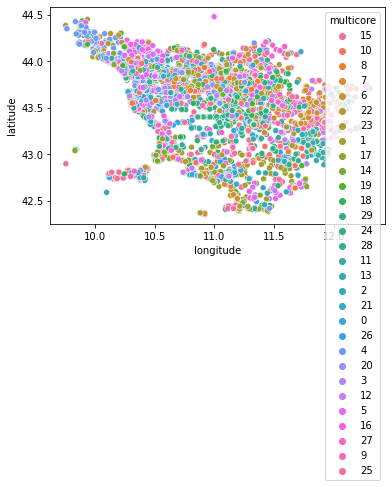

In [40]:
assign(G,multicore,'multicore')
for node in G.nodes:
    df.loc[node,'multicore'] = str(G.nodes[node]['multicore'])

sns.scatterplot(data = df[df.multicore.astype(int)<30], x='longitude',y='latitude',hue='multicore')

### greedy modularity

In [32]:
greedy_modularity = cd.greedy_modularity(G)
readwrite.write_community_json(greedy_modularity,'../data/communities/greedy_modularity.json')


<AxesSubplot:xlabel='longitude', ylabel='latitude'>

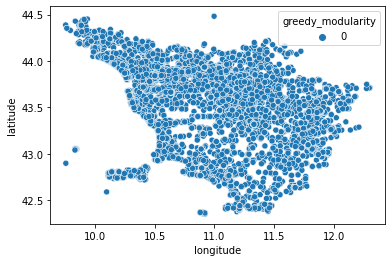

In [33]:
assign(G,greedy_modularity,'greedy_modularity')
for node in G.nodes:
    df.loc[node,'greedy_modularity'] = str(G.nodes[node]['greedy_modularity'])

sns.scatterplot(data = df[df.greedy_modularity.astype(int)<10], x='longitude',y='latitude',hue='greedy_modularity')

In [34]:
greedy_modularity = cd.greedy_modularity(G,weight='dissimilarity')
readwrite.write_community_json(greedy_modularity,'../data/communities/weighted_greedy_modularity.json')


<AxesSubplot:xlabel='longitude', ylabel='latitude'>

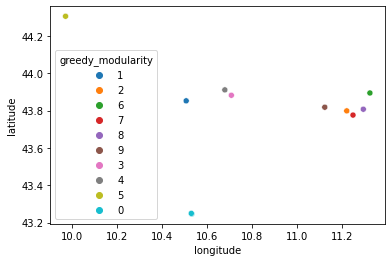

In [35]:
assign(G,greedy_modularity,'greedy_modularity')
for node in G.nodes:
    df.loc[node,'greedy_modularity'] = str(G.nodes[node]['greedy_modularity'])

sns.scatterplot(data = df[df.greedy_modularity.astype(int)<10], x='longitude',y='latitude',hue='greedy_modularity')

### Leiden

In [94]:
leiden= cd.leiden(G)

TypeError: The graph object should be either a networkx or an igraph one.

In [95]:
#readwrite.write_community_json(leiden,'../data/communities/leiden.json')
assign(G,leiden,'leiden')
for node in G.nodes:
    df.loc[node,'leiden'] = str(G.nodes[node]['leiden'])

sns.scatterplot(data = df[df.leiden.astype(int)<10], x='longitude',y='latitude',hue='leiden')

NameError: name 'leiden' is not defined

In [38]:
leiden= cd.leiden(G,weights='dissimilarity')

<AxesSubplot:xlabel='longitude', ylabel='latitude'>

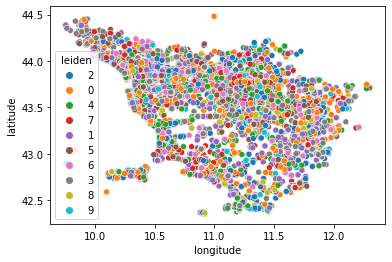

In [39]:
readwrite.write_community_json(leiden,'../data/communities/weighted_leiden.json')
assign(G,leiden,'leiden')
for node in G.nodes:
    df.loc[node,'leiden'] = str(G.nodes[node]['leiden'])

sns.scatterplot(data = df[df.leiden.astype(int)<10], x='longitude',y='latitude',hue='leiden')

<AxesSubplot:xlabel='longitude', ylabel='latitude'>

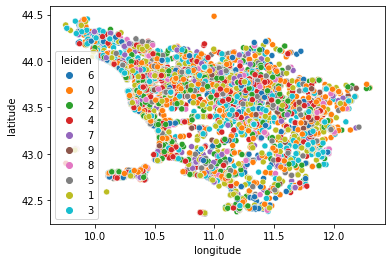

In [40]:
provincemapping = {e:i for i,e in enumerate(df.province.unique())}
for node in G.nodes:
    G.nodes[node]['provint'] = provincemapping[df.loc[node,'province']]
    
leiden_p= cd.leiden(G, initial_membership = [G.nodes[node]['provint'] for node in G.nodes], weights='dissimilarity')
readwrite.write_community_json(leiden_p,'../data/communities/leiden_wp.json')
assign(G,leiden_p,'leiden')
for node in G.nodes:
    df.loc[node,'leiden'] = str(G.nodes[node]['leiden'])
sns.scatterplot(data = df[df.leiden.astype(int)<10], x='longitude',y='latitude',hue='leiden')

<AxesSubplot:xlabel='longitude', ylabel='latitude'>

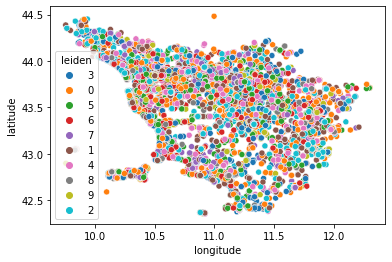

In [41]:
leiden_p= cd.leiden(G, initial_membership = [G.nodes[node]['provint'] for node in G.nodes])
readwrite.write_community_json(leiden_p,'../data/communities/leiden_p.json')
assign(G,leiden_p,'leiden')
for node in G.nodes:
    df.loc[node,'leiden'] = str(G.nodes[node]['leiden'])
sns.scatterplot(data = df[df.leiden.astype(int)<10], x='longitude',y='latitude',hue='leiden')

### Label Propagation

In [42]:
label_propagation = cd.label_propagation(G)
readwrite.write_community_json(label_propagation,'../data/communities/label_propagation.json')

<AxesSubplot:xlabel='longitude', ylabel='latitude'>

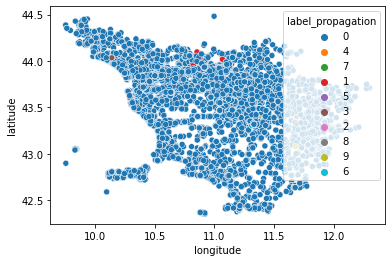

In [43]:

assign(G,label_propagation,'label_propagation')
for node in G.nodes:
    df.loc[node,'label_propagation'] = str(G.nodes[node]['label_propagation'])

sns.scatterplot(data = df[df.label_propagation.astype(int)<10], x='longitude',y='latitude',hue='label_propagation')

### Async Fluid


In [3]:
async_fluid = cd.async_fluid(G,k=7)
#readwrite.write_community_json(async_fluid,'../data/communitiesJ/async_fluid10.json')

<AxesSubplot:xlabel='longitude', ylabel='latitude'>

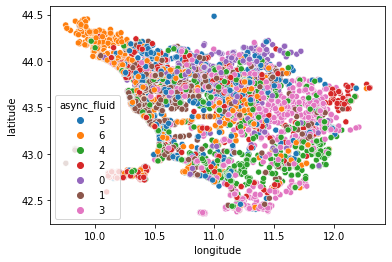

In [6]:
assign(G,async_fluid,'async_fluid')
for node in G.nodes:
    df.loc[node,'async_fluid'] = str(G.nodes[node]['async_fluid'])

sns.scatterplot(data = df[df.async_fluid.astype(int)<10], x='longitude',y='latitude',hue='async_fluid')

### Rb / Rber Pots

In [149]:

provinceMapping= { p:i for i,p in enumerate(df.province.unique())}
for node in G.nodes:
     G.nodes[node]['provint'] = provinceMapping[G.nodes[node]['province']]
                                            

In [48]:
for node in list(G.nodes())[:10]: print(G.nodes[node])

{'province': 'pisa', 'kmeans': '6', 'louvain': 4, 'greedy_modularity': 1, 'leiden': 3, 'provint': 0, 'label_propagation': 0, 'async_fluid': 6}
{'province': 'florence', 'kmeans': '1', 'louvain': 0, 'greedy_modularity': 2, 'leiden': 0, 'provint': 1, 'label_propagation': 0, 'async_fluid': 6}
{'province': 'pistoia', 'kmeans': '9', 'louvain': 4, 'greedy_modularity': 3, 'leiden': 3, 'provint': 4, 'label_propagation': 0, 'async_fluid': 6}
{'province': 'pistoia', 'kmeans': '9', 'louvain': 4, 'greedy_modularity': 4, 'leiden': 0, 'provint': 4, 'label_propagation': 0, 'async_fluid': 6}
{'province': 'massacarrara', 'kmeans': '2', 'louvain': 7, 'greedy_modularity': 5, 'leiden': 0, 'provint': 6, 'label_propagation': 0, 'async_fluid': 1}
{'province': 'prato', 'kmeans': '1', 'louvain': 4, 'greedy_modularity': 6, 'leiden': 0, 'provint': 2, 'label_propagation': 0, 'async_fluid': 4}
{'province': 'florence', 'kmeans': '1', 'louvain': 0, 'greedy_modularity': 7, 'leiden': 0, 'provint': 1, 'label_propagation

In [50]:

rb_pots = cd.rb_pots( G, initial_membership =[G.nodes[node]['provint'] for node in G.nodes()], resolution_parameter=0.7)


readwrite.write_community_json(rb_pots,'../data/communities/rb_pots.json')
print(len(rb_pots.communities),[len(c) for c in rb_pots.communities])

10 [3576, 3415, 2610, 1928, 1298, 1194, 937, 437, 83, 7]


In [71]:
for c in rb_pots.communities: print(len(c))

3335
2929
2712
2508
1741
1008
415
149
65
53
51
21
6
5
5


<AxesSubplot:xlabel='longitude', ylabel='latitude'>

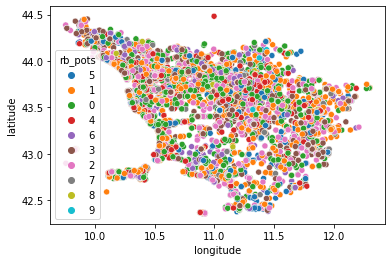

In [51]:
assign(G,rb_pots,'rb_pots')
for node in G.nodes:
    df.loc[node,'rb_pots'] = str(G.nodes[node]['rb_pots'])

sns.scatterplot(data = df[df.rb_pots.astype(int)<20], x='longitude',y='latitude',hue='rb_pots')

In [52]:
for node in G.nodes: G.nodes[node]['size'] = int(df.loc[node,'N_reviews'])

In [54]:
rber_pots = cd.rber_pots(G, initial_membership =[G.nodes[node]['provint'] for node in G.nodes()],node_sizes=[G.nodes[node]['size'] for node in G.nodes()] ,weights='dissimilarity',resolution_parameter=0.8)
readwrite.write_community_json(rber_pots,'../data/communities/rber_pots.json')
print(len(rber_pots.communities))

841


<AxesSubplot:xlabel='longitude', ylabel='latitude'>

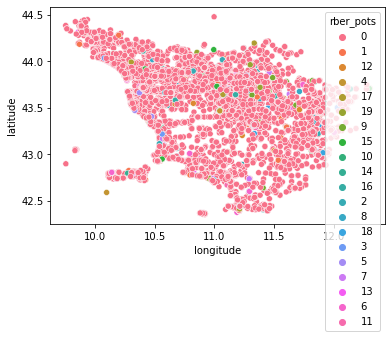

In [55]:
assign(G,rber_pots,'rber_pots')
for node in G.nodes:
    df.loc[node,'rber_pots'] = str(G.nodes[node]['rber_pots'])

sns.scatterplot(data = df[df.rber_pots.astype(int)<20], x='longitude',y='latitude',hue='rber_pots')

## Overlapping Communities

### Cuisines

In [16]:
allCuisines = set()
for i in df[~df.cuisines.isna()].index:
    for cuisine in df.loc[i,'cuisines'].split(', '):
    
        allCuisines.add(cuisine)
        
print(len(allCuisines))

110


In [17]:

communities = {cuisine: list() for cuisine in allCuisines}

for i in df[~df.cuisines.isna()].index:
    for cuisine in df.loc[i,'cuisines'].split(', '):
    
        communities[cuisine].append(i)
    

In [22]:
nodeCluster = dict()
nodeCluster['communities'] = list(communities.values())
nodeCluster['coverage'] = len(df[~df.cuisines.isna()])/len(df)
nodeCluster['algorithm'] = 'cuisines'
nodeCluster['params'] = {}
nodeCluster['overlap'] = True

with open('../data/communities/cuisines.json','w+') as jf:
    json.dump(nodeCluster,jf)

In [26]:
cuisines = readwrite.read_community_json(f'../data/communities/cuisines.json')

In [27]:
data = {'cuisines':cuisines}

In [29]:
scores = {'cuisines':{}}
for evaluation_function in evaluation_functions:
    f_name = str(evaluation_function).split(' ')[1].upper()
    print(f_name)
    for name, comm in data.items():
        print(name,end= ' -> ')
        try: 
            ev = evaluation_function(G,comm)
            print(ev)
            scores[name][f_name] = ev.score
            
        except Exception as e: 
            print(e) 
            scores[name][f_name] = np.nan
            
    print('\n\n')

AVG_EMBEDDEDNESS
cuisines -> FitnessResult(min=0.0, max=0.7846062666178951, score=0.039557648057832996, std=0.10005777458898465)



AVERAGE_INTERNAL_DEGREE
cuisines -> FitnessResult(min=0.0, max=14.644637778149573, score=0.6476245814910729, std=1.7350993451796577)



AVG_TRANSITIVITY
cuisines -> FitnessResult(min=0.0, max=0.25925925925925924, score=0.025995368339761783, std=0.05367058958454203)



CONDUCTANCE
cuisines -> FitnessResult(min=0.19125758793691272, max=1.0, score=0.9629319830561098, std=0.09887971333609584)



CUT_RATIO
cuisines -> FitnessResult(min=6.665777896280495e-05, max=0.0027331511232584495, score=0.0010869062514785052, std=0.00043548915007586797)



EDGES_INSIDE
cuisines -> FitnessResult(min=0, max=87531, score=1307.909090909091, std=8541.801121059629)



EXPANSION
cuisines -> FitnessResult(min=1.0, max=41.0, score=15.876104105174868, std=6.70730238849896)



FRACTION_OVER_MEDIAN_DEGREE
cuisines -> FitnessResult(min=0.0, max=0.4992471139367576, score=0.14533128530540

C:\Users\carlo\Anaconda3\lib\site-packages\cdlib\evaluation\fitness.py:812: RuntimeWarning: divide by zero encountered in log
  q += binom_c * (pc * np.log(pc / p) + (1 - pc) * np.log((1 - pc) / (1 - p)))
C:\Users\carlo\Anaconda3\lib\site-packages\cdlib\evaluation\fitness.py:812: RuntimeWarning: invalid value encountered in double_scalars
  q += binom_c * (pc * np.log(pc / p) + (1 - pc) * np.log((1 - pc) / (1 - p)))


FitnessResult(min=None, max=None, score=nan, std=None)



SIZE
cuisines -> FitnessResult(min=1, max=11954, score=396.7090909090909, std=1427.4970042665877)



SURPRISE
cuisines -> FitnessResult(min=None, max=None, score=634.4670453440772, std=None)



TRIANGLE_PARTICIPATION_RATIO
cuisines -> FitnessResult(min=0.0, max=0.6960849924711394, score=0.059846746314208686, std=0.1311532201165675)





In [35]:
fdf['cusines'] = scores['cuisines'].values()
fdf[['cusines','demon']]

KeyError: ('cusines', 'demon')

### Angel 

In [56]:
angel = cd.angel(G, min_community_size=10, threshold=0.2)
readwrite.write_community_json(angel,'../data/communities/angel.json')

In [57]:
print(len(angel.communities))
print([len(c) for c in angel.communities ])

6
[8955, 30, 20, 19, 15, 10]


In [30]:
assign(G,angel,'angel',overlap=True)


#sns.scatterplot(data = df[df.greedy_modularity.astype(int)<10], x='longitude',y='latitude',hue='angel')

### Demon

In [58]:
demon = cd.demon(G, min_com_size=10,epsilon=0.1)
print(len(demon.communities))
readwrite.write_community_json(demon,'../data/communities/demon.json')

135


In [59]:
print([len(c) for c in demon.communities ])

[2801, 2574, 2089, 1766, 1634, 1513, 1481, 1469, 1440, 1435, 1323, 1186, 1111, 1098, 1012, 994, 949, 934, 933, 904, 820, 819, 815, 788, 781, 767, 747, 745, 735, 719, 711, 710, 697, 693, 689, 684, 684, 680, 664, 635, 631, 630, 619, 619, 614, 607, 598, 595, 592, 591, 589, 587, 585, 583, 579, 577, 572, 568, 566, 560, 548, 545, 541, 538, 536, 530, 515, 509, 496, 494, 491, 490, 472, 470, 463, 461, 459, 454, 453, 444, 430, 428, 425, 415, 415, 413, 403, 380, 380, 379, 374, 365, 359, 356, 340, 333, 331, 330, 315, 308, 307, 305, 302, 300, 291, 288, 276, 269, 265, 261, 259, 250, 242, 209, 207, 174, 166, 166, 165, 163, 158, 87, 64, 50, 46, 34, 31, 24, 23, 22, 19, 16, 14, 11, 11]


## Evaluation


In [47]:
G = nx.read_weighted_edgelist('../data/connected.weighted.edgelist')
G = nx.relabel_nodes(G, {node:int(node) for node in G.nodes}) 
df = pd.read_csv('../data/connencted.csv',index_col=0)
#for node in G.nodes:
 #   G.nodes[node]['province'] = df.loc[node,'province']
df.head()

,index,position,name,city,menu,link,score,N_reviews,price,Name,...,latitude,longitude,cuisines,meals,specialDiets,positionlink,province,Link,provinceOK,longitud§e
0,0,2018,Osteria al Borgo,Lucca,False,/Restaurant_Review-g187898-d23137800-Reviews-O...,5.0,6,NaN,Osteria al Borgo,...,43.851808,10.506207,"Pizza, Tuscan, Central-Italian",NaN,"Vegetarian Friendly, Vegan Options, Gluten Fre...",j39_https://maps.google.com/maps?saddr=&daddr=...,pisa,/Restaurant_Review-g187898-d23137800-Reviews-O...,0,10.495633
1,12,1309,Il Genio Italiano,Florence,True,/Restaurant_Review-g187895-d2483611-Reviews-Il...,4.0,229,2.5,Il Genio Italiano,...,43.798058,11.219482,"Italian, Pizza, Mediterranean, Tuscan, Central...",NaN,Vegetarian Friendly,vs1_https://maps.google.com/maps?saddr=&daddr=...,florence,/Restaurant_Review-g187895-d2483611-Reviews-Il...,1,NaN
2,37,1316,La Taverna,Scandicci,False,/Restaurant_Review-g644284-d2660933-Reviews-La...,4.0,236,2.5,La Taverna,...,43.764280,11.180183,"Italian, Pizza, Seafood, Mediterranean",NaN,Vegetarian Friendly,zhJ_https://maps.google.com/maps?saddr=&daddr=...,florence,/Restaurant_Review-g644284-d2660933-Reviews-La...,1,NaN
3,48,1301,Bar Pasticceria Deanna,Florence,False,/Restaurant_Review-g187895-d2077023-Reviews-Ba...,4.0,162,1.0,Bar Pasticceria Deanna,...,43.775550,11.247292,"Italian, Bar, Cafe, Deli",NaN,"Vegetarian Friendly, Vegan Options, Gluten Fre...",hSR_https://maps.google.com/maps?saddr=&daddr=...,florence,/Restaurant_Review-g187895-d2077023-Reviews-Ba...,1,NaN
4,50,1332,Perseus Fiesolano,Fiesole,True,/Restaurant_Review-g187896-d2720609-Reviews-Pe...,3.5,754,2.5,Perseus Fiesolano,...,43.806915,11.293199,"Italian, Mediterranean, Barbecue, Tuscan, Cent...","Lunch, Dinner",Gluten Free Options,d5H_https://maps.google.com/maps?saddr=&daddr=...,florence,/Restaurant_Review-g187896-d2720609-Reviews-Pe...,1,NaN


In [48]:
nx.is_connected(G)

True

In [14]:
import os 
data = dict()


for f in os.listdir('../data/communitiesW'):
    if f[-5:] != '.json': continue
   
    name = f[:-5]
    
    communities = readwrite.read_community_json(f'../data/communitiesW/{f}')
    data[name] = communities
    print(name,' -> ',len(communities.communities),' -> ', [len(c) for c in communities.communities[:20]])

angel  ->  3  ->  [8076, 95, 10]
async_fluid_5  ->  5  ->  [3355, 3216, 3106, 2772, 2554]
async_fluid_7  ->  7  ->  [2615, 2236, 2232, 2227, 2093, 1823, 1777]
best_demon  ->  88  ->  [2762, 2686, 2192, 1937, 1795, 1626, 1508, 1451, 1311, 1176, 1094, 1038, 1034, 1016, 943, 920, 888, 874, 861, 846]
demon  ->  220  ->  [1216, 1057, 992, 989, 846, 844, 816, 747, 744, 735, 722, 707, 701, 699, 670, 665, 644, 632, 627, 620]
greedy_modularity  ->  67  ->  [11628, 2719, 225, 117, 40, 37, 20, 13, 11, 8, 7, 7, 6, 6, 5, 5, 5, 5, 5, 4]
kmeans  ->  10  ->  [3452, 2439, 1946, 1615, 1144, 1095, 1060, 1053, 751, 448]
label_propagation  ->  589  ->  [3830, 3614, 2306, 648, 572, 391, 271, 217, 176, 92, 75, 67, 58, 55, 53, 52, 47, 45, 43, 41]
leiden  ->  17  ->  [2217, 1995, 1741, 1498, 1363, 1169, 1160, 1088, 821, 662, 540, 391, 155, 57, 50, 49, 47]
leiden_p  ->  20  ->  [2070, 2031, 1841, 1831, 1691, 1421, 1280, 1037, 792, 380, 222, 117, 87, 67, 58, 48, 14, 6, 6, 4]
leiden_wp  ->  21  ->  [2067, 2061, 2

### Collect Fitness

In [50]:
all_evalution_functions = [evaluation.avg_distance, evaluation.avg_embeddedness, evaluation.average_internal_degree, evaluation.avg_transitivity, evaluation.conductance, evaluation.cut_ratio, evaluation.edges_inside, evaluation.expansion,  evaluation.fraction_over_median_degree,  evaluation.hub_dominance,  evaluation.internal_edge_density, evaluation.normalized_cut, evaluation.max_odf, evaluation.avg_odf, evaluation.flake_odf, evaluation.scaled_density, evaluation.significance, evaluation.size , evaluation.surprise , evaluation.triangle_participation_ratio, evaluation.purity]  

In [23]:
evaluation_functions = [ evaluation.avg_embeddedness, evaluation.average_internal_degree, evaluation.avg_transitivity, evaluation.conductance, evaluation.cut_ratio, evaluation.edges_inside, evaluation.expansion,  evaluation.fraction_over_median_degree,  evaluation.hub_dominance,  evaluation.internal_edge_density, evaluation.normalized_cut, evaluation.max_odf, evaluation.avg_odf, evaluation.flake_odf, evaluation.scaled_density, evaluation.significance, evaluation.size , evaluation.surprise , evaluation.triangle_participation_ratio]  

In [52]:
scores = {name:{} for name in data.keys() }
for evaluation_function in evaluation_functions:
    f_name = str(evaluation_function).split(' ')[1].upper()
    print(f_name)
    for name, comm in data.items():
        print(name,end= ' -> ')
        try: 
            ev = evaluation_function(G,comm)
            print(ev)
            scores[name][f_name] = ev.score
            
        except Exception as e: 
            print(e) 
            scores[name][f_name] = np.nan
            
    print('\n\n')

AVG_EMBEDDEDNESS
angel -> FitnessResult(min=0.0, max=0.6057805107395245, score=0.22928925294166938, std=0.2683204917919616)
async_fluid_5 -> FitnessResult(min=0.6030970334195757, max=0.7141848199607456, score=0.6474132275106634, std=0.0385441850797324)
async_fluid_7 -> FitnessResult(min=0.5857753954660431, max=0.6872416565150626, score=0.6288728811292638, std=0.032873228533212465)
best_demon -> FitnessResult(min=0.0, max=0.21414737469083572, score=0.07127918474978336, std=0.04104809578702195)
demon -> FitnessResult(min=0.13116230559654155, max=0.8247654019763412, score=0.38745127698592213, std=0.08013841666996586)
greedy_modularity -> FitnessResult(min=0.5555555555555555, max=0.968694838723538, score=0.7660735165352626, std=0.08471244463644868)
kmeans -> FitnessResult(min=0.48803864266821867, max=0.6765166289161176, score=0.5897501979047435, std=0.06698157252254024)
label_propagation -> FitnessResult(min=0.15476190476190477, max=0.9, score=0.5933040659443446, std=0.14979176414645512)
l

leiden_p -> FitnessResult(min=0.7266211316299857, max=1.0, score=0.9216510105587069, std=0.07895465209913503)
leiden_wp -> FitnessResult(min=0.761804745235317, max=1.0, score=0.9261244466929481, std=0.07373519198778491)
louvain -> FitnessResult(min=0.077859497844281, max=0.5094446010713278, score=0.3274949588993304, std=0.11680217709965669)
multicore -> FitnessResult(min=0.4220746344223725, max=0.5050979454511297, score=0.47956166505956505, std=0.034005538148501574)
provinces -> FitnessResult(min=0.30632175339197854, max=0.5605214152700186, score=0.4251295714218518, std=0.0694238292118083)
rber_pots -> FitnessResult(min=0.1506102944765133, max=1.0, score=0.9957148285568191, std=0.03483291804266043)
rb_pots -> FitnessResult(min=0.7273902412434394, max=1.0, score=0.8992600543356883, std=0.0917223712636496)
weighted_greedy_modularity -> FitnessResult(min=0.021804833331331788, max=0.47368421052631576, score=0.30488393906183714, std=0.10151805283896827)
weighted_leiden -> FitnessResult(min=

weighted_rb_pots -> FitnessResult(min=6.5, max=26.2, score=15.890722564165978, std=4.555262774776012)



FRACTION_OVER_MEDIAN_DEGREE
angel -> FitnessResult(min=0.0, max=0.48031203566121844, score=0.2794022575011079, std=0.20379027599483832)
async_fluid_5 -> FitnessResult(min=0.463618802318094, max=0.49314574314574317, score=0.4780973298919293, std=0.010158167696211253)
async_fluid_7 -> FitnessResult(min=0.44682048396173324, max=0.4983277591973244, score=0.47760556422484185, std=0.016820500310593588)
best_demon -> FitnessResult(min=0.0, max=0.5, score=0.3582988198839265, std=0.10768850117945698)
demon -> FitnessResult(min=0.25, max=0.5, score=0.46825003993977793, std=0.0406665005896588)
greedy_modularity -> FitnessResult(min=0.0, max=0.5, score=0.2401865179638359, std=0.19015692947830432)
kmeans -> FitnessResult(min=0.46765734265734266, max=0.4976825028968714, score=0.48227586041459897, std=0.009797775222972755)
label_propagation -> FitnessResult(min=0.0, max=0.5, score=0.20286043105237

angel -> FitnessResult(min=0.0, max=7.378003885404418, score=2.895389676495393, std=3.2143632464800267)
async_fluid_5 -> FitnessResult(min=2.5464444918420908, max=3.351691996070556, score=3.133313942890345, std=0.29936653549863385)
async_fluid_7 -> FitnessResult(min=2.8423502622823342, max=5.106687435921678, score=4.190336698796124, std=0.8416853157517692)
best_demon -> FitnessResult(min=0.0, max=2.816020312572973, score=1.4521377761022511, std=0.4520343966919174)
demon -> FitnessResult(min=11.38718425031981, max=583.9857757204084, score=76.45238700698228, std=95.01175383285006)
greedy_modularity -> FitnessResult(min=1.156080125493803, max=823.5696837082681, score=526.0521916184553, std=241.90143637570438)
kmeans -> FitnessResult(min=2.619444555821417, max=19.699278847887726, score=7.751837053294068, std=4.914734869041019)
label_propagation -> FitnessResult(min=2.4225119868490608, max=823.5696837082681, score=590.733393475352, std=220.01699180945045)
leiden -> FitnessResult(min=1.04235

C:\Users\carlo\Anaconda3\lib\site-packages\cdlib\evaluation\fitness.py:812: RuntimeWarning: divide by zero encountered in log
  q += binom_c * (pc * np.log(pc / p) + (1 - pc) * np.log((1 - pc) / (1 - p)))
C:\Users\carlo\Anaconda3\lib\site-packages\cdlib\evaluation\fitness.py:812: RuntimeWarning: invalid value encountered in double_scalars
  q += binom_c * (pc * np.log(pc / p) + (1 - pc) * np.log((1 - pc) / (1 - p)))


FitnessResult(min=None, max=None, score=nan, std=None)
async_fluid_5 -> FitnessResult(min=None, max=None, score=397966.57826587313, std=None)
async_fluid_7 -> FitnessResult(min=None, max=None, score=421808.9734925168, std=None)
best_demon -> FitnessResult(min=None, max=None, score=nan, std=None)
demon -> FitnessResult(min=None, max=None, score=3347546.3649165737, std=None)
greedy_modularity -> FitnessResult(min=None, max=None, score=nan, std=None)
kmeans -> FitnessResult(min=None, max=None, score=402579.02546301525, std=None)
label_propagation -> FitnessResult(min=None, max=None, score=nan, std=None)
leiden -> FitnessResult(min=None, max=None, score=67093.63415384256, std=None)
leiden_p -> FitnessResult(min=None, max=None, score=nan, std=None)
leiden_wp -> FitnessResult(min=None, max=None, score=nan, std=None)
louvain -> FitnessResult(min=None, max=None, score=496710.59698093525, std=None)
multicore -> FitnessResult(min=None, max=None, score=295663.4052317353, std=None)
provinces -> Fi

C:\Users\carlo\Anaconda3\lib\site-packages\cdlib\evaluation\fitness.py:769: RuntimeWarning: invalid value encountered in log2
  sp = m * (q * np.log(q / qa) + (1 - q) * np.log2((1 - q) / (1 - qa)))


FitnessResult(min=None, max=None, score=nan, std=None)
greedy_modularity -> FitnessResult(min=None, max=None, score=36735.71592007527, std=None)
kmeans -> FitnessResult(min=None, max=None, score=58277.06728215988, std=None)
label_propagation -> FitnessResult(min=None, max=None, score=74770.77951112443, std=None)
leiden -> FitnessResult(min=None, max=None, score=-1192.8014288370607, std=None)
leiden_p -> FitnessResult(min=None, max=None, score=-1322.8646505682304, std=None)
leiden_wp -> FitnessResult(min=None, max=None, score=-1315.8640505184462, std=None)
louvain -> FitnessResult(min=None, max=None, score=109373.17479905527, std=None)
multicore -> FitnessResult(min=None, max=None, score=8749.839423841422, std=None)
provinces -> FitnessResult(min=None, max=None, score=61775.45701246686, std=None)
rber_pots -> FitnessResult(min=None, max=None, score=1866.3844360578087, std=None)
rb_pots -> FitnessResult(min=None, max=None, score=-1599.3303055104545, std=None)
weighted_greedy_modularity -

In [53]:
fdf = pd.DataFrame(scores)#, index = [name for name in data.keys()],columns = [str(evaluation_function).split(' ')[1].upper() for evaluation_function in evaluation_functions])

fdf

,angel,async_fluid_5,async_fluid_7,best_demon,demon,greedy_modularity,kmeans,label_propagation,leiden,leiden_p,leiden_wp,louvain,multicore,provinces,rber_pots,rb_pots,weighted_greedy_modularity,weighted_leiden,weighted_louvain,weighted_rb_pots
AVG_EMBEDDEDNESS,0.229289,0.647413,0.628873,0.071279,3.874513e-01,0.766074,0.589750,0.593304,0.110566,0.092590,0.088229,0.699009,0.571367,0.601829,0.006972,0.118142,0.766074,0.091709,0.701913,0.112544
AVERAGE_INTERNAL_DEGREE,4.556168,11.445435,11.101579,1.062219,1.288944e+01,2.990350,10.462893,2.273236,1.629297,1.370315,1.302677,13.097139,9.523394,10.778917,0.055473,1.761251,2.990350,1.343281,11.036344,1.729772
AVG_TRANSITIVITY,0.086832,0.196938,0.203799,0.056625,6.034796e-01,0.045763,0.170878,0.111294,0.079797,0.061757,0.057599,0.320314,0.162537,0.168455,0.002904,0.074292,0.045763,0.069606,0.263615,0.062921
CONDUCTANCE,0.775809,0.368465,0.387894,0.943509,6.219615e-01,0.304884,0.442512,0.487978,0.907099,0.921651,0.926124,0.327495,0.479562,0.425130,0.995715,0.899260,0.304884,0.923741,0.325605,0.900927
CUT_RATIO,0.001360,0.000552,0.000522,0.001244,1.407540e-03,0.000065,0.000601,0.000136,0.001142,0.001069,0.001084,0.000440,0.000782,0.000580,0.000714,0.001148,0.000065,0.001080,0.000386,0.001136
EDGES_INSIDE,17277.666667,17392.200000,12277.571429,508.647727,2.231627e+03,1956.656716,7980.800000,155.578947,1046.117647,1004.300000,947.428571,4168.809524,17808.250000,8012.700000,121.006281,1685.866667,1956.656716,777.190476,4188.333333,2116.066667
EXPANSION,17.348968,6.614978,6.698830,17.866397,2.067839e+01,0.942073,8.149616,2.033811,16.104925,15.170720,15.438975,6.261093,8.787621,7.836483,10.693509,16.063637,0.942073,15.372690,5.455560,15.890723
FRACTION_OVER_MEDIAN_DEGREE,0.279402,0.478097,0.477606,0.358299,4.682500e-01,0.240187,0.482276,0.202860,0.380210,0.276285,0.287662,0.471339,0.478090,0.480014,0.019455,0.321487,0.240187,0.316737,0.454226,0.300613
HUB_DOMINANCE,0.031258,0.026817,0.033560,0.014634,2.651779e-01,0.843093,0.047249,0.924132,0.026743,0.020685,0.019734,0.268093,0.019055,0.046773,NaN,0.022280,0.843093,0.033899,0.204365,0.033280
INTERNAL_EDGE_DENSITY,0.000879,0.000951,0.001272,0.000441,2.320763e-02,0.159687,0.002353,0.179321,0.000762,0.000554,0.000761,0.033053,0.000657,0.002277,0.001541,0.000608,0.159687,0.001783,0.021822,0.001425


In [54]:
fdf.to_csv('../data/fitnessMeasures.csv')

### Collect Modularities

In [55]:
all_modularities = [evaluation.erdos_renyi_modularity, evaluation.link_modularity , evaluation.modularity_density , evaluation.newman_girvan_modularity , evaluation.z_modularity]

In [56]:
scores = {name:{} for name in data.keys() }
for modularity in all_modularities:
    m_name = str(modularity).split(' ')[1].upper()
    print(m_name)
    for name, comm in data.items():
        print(name,end= ' -> ')
        try: 
            mod=modularity(G,comm)
            print(mod)
            scores[name][m_name] = mod.score
            
        except Exception as e:
            print(e) 
            scores[name][m_name] = np.nan
            
    print('\n\n')

ERDOS_RENYI_MODULARITY
angel -> FitnessResult(min=None, max=None, score=0.08954106095325981, std=None)
async_fluid_5 -> FitnessResult(min=None, max=None, score=0.4345176937589837, std=None)
async_fluid_7 -> FitnessResult(min=None, max=None, score=0.48399030434271934, std=None)
best_demon -> FitnessResult(min=None, max=None, score=0.059793717055067336, std=None)
demon -> FitnessResult(min=None, max=None, score=3.4540542433578274, std=None)
greedy_modularity -> FitnessResult(min=None, max=None, score=0.32556394338533595, std=None)
kmeans -> FitnessResult(min=None, max=None, score=0.45187096711564195, std=None)
label_propagation -> FitnessResult(min=None, max=None, score=0.5189131532116278, std=None)
leiden -> FitnessResult(min=None, max=None, score=0.03462270932977639, std=None)
leiden_p -> FitnessResult(min=None, max=None, score=0.04221971822996884, std=None)
leiden_wp -> FitnessResult(min=None, max=None, score=0.03964685823053763, std=None)
louvain -> FitnessResult(min=None, max=None, 

weighted_greedy_modularity -> FitnessResult(min=None, max=None, score=0.32829290696234986, std=None)
weighted_leiden -> FitnessResult(min=None, max=None, score=0.11497011469577387, std=None)
weighted_louvain -> FitnessResult(min=None, max=None, score=1.871704820658544, std=None)
weighted_rb_pots -> FitnessResult(min=None, max=None, score=0.10559949893213089, std=None)





In [57]:
mdf = pd.DataFrame(scores)#, index = [name for name in data.keys()],columns = [str(modularity).split(' ')[1].upper() for modularity in all_modularities])
mdf

,angel,async_fluid_5,async_fluid_7,best_demon,demon,greedy_modularity,kmeans,label_propagation,leiden,leiden_p,leiden_wp,louvain,multicore,provinces,rber_pots,rb_pots,weighted_greedy_modularity,weighted_leiden,weighted_louvain,weighted_rb_pots
ERDOS_RENYI_MODULARITY,0.089541,0.434518,0.483990,0.059794,3.454054,0.325564,0.451871,0.518913,0.034623,0.042220,0.039647,0.554352,0.263344,0.459585,0.197615,0.047074,0.325564,0.035236,0.554840,0.049403
LINK_MODULARITY,0.054772,0.092060,0.090983,NaN,0.123409,0.138784,0.084488,0.097010,0.018827,0.021264,0.021063,0.092679,0.075410,0.084826,0.101969,0.026771,0.138784,0.017278,0.093113,0.033602
MODULARITY_DENSITY,-38.378399,24.152286,30.819237,-1478.767718,-1713.568821,137.234579,23.132766,141.021338,-246.085684,-276.008089,-296.862242,143.556975,2.943092,29.424347,-8467.876216,-214.535793,137.234579,-294.617572,117.196471,-212.414262
NEWMAN_GIRVAN_MODULARITY,-0.244769,0.518360,0.585708,0.000006,0.147370,0.318050,0.661938,0.607829,0.090609,0.105329,0.101484,0.689315,0.314829,0.666176,0.121134,0.108345,0.318050,0.089431,0.703652,0.107779
Z_MODULARITY,0.019254,1.055664,1.298426,0.120468,6.145115,0.328293,1.364148,1.329308,0.109818,0.121416,0.117165,1.912332,0.606504,1.423812,0.052354,0.111507,0.328293,0.114970,1.871705,0.105599


In [58]:
mdf.to_csv('../data/modularityMeasures.csv')

In [82]:
mdf.transpose()

,ERDOS_RENYI_MODULARITY,LINK_MODULARITY,MODULARITY_DENSITY,NEWMAN_GIRVAN_MODULARITY,Z_MODULARITY
angel,0.043196,5.455227e-02,-109.778013,-0.326231,0.009388
async_fluid10,0.459781,8.103319e-02,22.268439,0.557399,1.507329
async_fluid7,0.487919,9.136916e-02,35.941770,0.580483,1.382000
demon,3.115386,1.172373e-01,-890.209844,0.230205,6.529580
greedy_modularity,0.000000,1.446590e-01,19.670778,0.000000,NaN
kmeans,0.468434,8.713390e-02,31.666932,0.502586,1.405646
label_propagation,0.046368,1.436484e-01,77.491360,0.078011,0.100973
leiden,0.033180,2.048578e-02,-188.380877,0.046977,0.102311
leiden_p,0.035163,2.188677e-02,-215.904405,0.046157,0.105236
leiden_wp,0.033265,2.202069e-02,-251.095928,0.045896,0.103611


In [83]:
m_df.columns

Index(['angel', 'async_fluid10', 'async_fluid7', 'demon', 'greedy_modularity',
       'kmeans', 'label_propagation', 'leiden', 'leiden_p', 'leiden_wp',
       'louvain', 'multicore', 'provinces', 'rber_pots', 'rb_pots',
       'weighted_greedy_modularity', 'weighted_leiden'],
      dtype='object')

In [84]:
 for name, comm in data.items():
        if comm.node_coverage==1:
            print(name,' -> ', evaluation.adjusted_mutual_information(comm, data['provinces']).score)

async_fluid10  ->  0.27597804969986595
async_fluid7  ->  0.3160422523014557
greedy_modularity  ->  -7.685799456268897e-16
kmeans  ->  0.70976079374463
label_propagation  ->  0.014743386119135444
leiden  ->  0.018403833463819994
leiden_p  ->  0.020295636961774784
leiden_wp  ->  0.020857991126838123
louvain  ->  0.5240196777074465
multicore  ->  0.2257026498397007
provinces  ->  1.0
rber_pots  ->  0.005266759444274312
rb_pots  ->  0.020851158732681858
weighted_greedy_modularity  ->  2.0894126904839363e-05
weighted_leiden  ->  0.0179950202591776


## MORE

In [2]:
import os 
data = dict()


for f in os.listdir('../data/communitiesW'):
    if f[-5:] != '.json': continue
   
    name = f[:-5]
    
    communities = readwrite.read_community_json(f'../data/communitiesW/{f}')
    data[name] = communities
    print(name,' -> ',len(communities.communities),' -> ', [len(c) for c in communities.communities[:20]])

angel  ->  3  ->  [8076, 95, 10]
async_fluid_5  ->  5  ->  [3355, 3216, 3106, 2772, 2554]
async_fluid_7  ->  7  ->  [2615, 2236, 2232, 2227, 2093, 1823, 1777]
best_demon  ->  88  ->  [2762, 2686, 2192, 1937, 1795, 1626, 1508, 1451, 1311, 1176, 1094, 1038, 1034, 1016, 943, 920, 888, 874, 861, 846]
demon  ->  220  ->  [1216, 1057, 992, 989, 846, 844, 816, 747, 744, 735, 722, 707, 701, 699, 670, 665, 644, 632, 627, 620]
greedy_modularity  ->  67  ->  [11628, 2719, 225, 117, 40, 37, 20, 13, 11, 8, 7, 7, 6, 6, 5, 5, 5, 5, 5, 4]
kmeans  ->  10  ->  [3452, 2439, 1946, 1615, 1144, 1095, 1060, 1053, 751, 448]
label_propagation  ->  589  ->  [3830, 3614, 2306, 648, 572, 391, 271, 217, 176, 92, 75, 67, 58, 55, 53, 52, 47, 45, 43, 41]
leiden  ->  17  ->  [2217, 1995, 1741, 1498, 1363, 1169, 1160, 1088, 821, 662, 540, 391, 155, 57, 50, 49, 47]
leiden_p  ->  20  ->  [2070, 2031, 1841, 1831, 1691, 1421, 1280, 1037, 792, 380, 222, 117, 87, 67, 58, 48, 14, 6, 6, 4]
leiden_wp  ->  21  ->  [2067, 2061, 2

In [3]:
G = nx.read_weighted_edgelist('../data/connected.weighted.edgelist')
G = nx.relabel_nodes(G, {node:int(node) for node in G.nodes}) 
mdf = pd.read_csv('../data/modularityMeasures.csv',index_col=0)
fdf = pd.read_csv('../data/fitnessMeasures.csv',index_col=0)

In [61]:
mdf.transpose()

,ERDOS_RENYI_MODULARITY,LINK_MODULARITY,MODULARITY_DENSITY,NEWMAN_GIRVAN_MODULARITY,Z_MODULARITY
angel,0.089541,0.054772,-38.378399,-0.244769,0.019254
async_fluid_5,0.434518,0.092060,24.152286,0.518360,1.055664
async_fluid_7,0.483990,0.090983,30.819237,0.585708,1.298426
best_demon,0.059794,NaN,-1478.767718,0.000006,0.120468
demon,3.454054,0.123409,-1713.568821,0.147370,6.145115
greedy_modularity,0.325564,0.138784,137.234579,0.318050,0.328293
kmeans,0.451871,0.084488,23.132766,0.661938,1.364148
label_propagation,0.518913,0.097010,141.021338,0.607829,1.329308
leiden,0.034623,0.018827,-246.085684,0.090609,0.109818
leiden_p,0.042220,0.021264,-276.008089,0.105329,0.121416


In [62]:
fdf.transpose()

,AVG_EMBEDDEDNESS,AVERAGE_INTERNAL_DEGREE,AVG_TRANSITIVITY,CONDUCTANCE,CUT_RATIO,EDGES_INSIDE,EXPANSION,FRACTION_OVER_MEDIAN_DEGREE,HUB_DOMINANCE,INTERNAL_EDGE_DENSITY,NORMALIZED_CUT,MAX_ODF,AVG_ODF,FLAKE_ODF,SCALED_DENSITY,SIGNIFICANCE,SIZE,SURPRISE,TRIANGLE_PARTICIPATION_RATIO
angel,0.229289,4.556168,0.086832,0.775809,0.001360,17277.666667,17.348968,0.279402,0.031258,0.000879,0.867893,65.333333,17.348968,0.712273,2.895390,NaN,2727.000000,-2532.782428,0.303210
async_fluid_5,0.647413,11.445435,0.196938,0.368465,0.000552,17392.200000,6.614978,0.478097,0.026817,0.000951,0.445527,48.200000,6.614978,0.251121,3.133314,3.979666e+05,3000.600000,43489.946534,0.675817
async_fluid_7,0.628873,11.101579,0.203799,0.387894,0.000522,12277.571429,6.698830,0.477606,0.033560,0.001272,0.443213,44.428571,6.698830,0.280275,4.190337,4.218090e+05,2143.285714,65066.070215,0.666123
best_demon,0.071279,1.062219,0.056625,0.943509,0.001244,508.647727,17.866397,0.358299,0.014634,0.000441,0.981956,77.590909,17.866397,0.970451,1.452138,NaN,645.829545,-2271.084698,0.106210
demon,0.387451,12.889440,0.603480,0.621961,0.001408,2231.627273,20.678389,0.468250,0.265178,0.023208,0.645114,65.368182,20.678389,0.703000,76.452387,3.347546e+06,307.877273,NaN,1.000000
greedy_modularity,0.766074,2.990350,0.045763,0.304884,0.000065,1956.656716,0.942073,0.240187,0.843093,0.159687,0.307563,3.835821,0.942073,0.062761,526.052192,NaN,223.925373,36735.715920,0.069156
kmeans,0.589750,10.462893,0.170878,0.442512,0.000601,7980.800000,8.149616,0.482276,0.047249,0.002353,0.485119,58.900000,8.149616,0.342788,7.751837,4.025790e+05,1500.300000,58277.067282,0.680727
label_propagation,0.593304,2.273236,0.111294,0.487978,0.000136,155.578947,2.033811,0.202860,0.924132,0.179321,0.488574,4.828523,2.033811,0.308655,590.733393,NaN,25.471986,74770.779511,0.155651
leiden,0.110566,1.629297,0.079797,0.907099,0.001142,1046.117647,16.104925,0.380210,0.026743,0.000762,0.954970,71.411765,16.104925,0.944720,2.509165,6.709363e+04,882.529412,-1192.801429,0.171906
leiden_p,0.092590,1.370315,0.061757,0.921651,0.001069,1004.300000,15.170720,0.276285,0.020685,0.000554,0.961365,63.300000,15.170720,0.951430,1.824334,NaN,750.150000,-1322.864651,0.143998


In [41]:
for name, comm in data.items():
    print(name,len(comm.communities),[len(c) for c in comm.communities[:10]])

angel 3 [8076, 95, 10]
async_fluid_5 5 [3355, 3216, 3106, 2772, 2554]
async_fluid_7 7 [2615, 2236, 2232, 2227, 2093, 1823, 1777]
best_demon 88 [2762, 2686, 2192, 1937, 1795, 1626, 1508, 1451, 1311, 1176]
demon 220 [1216, 1057, 992, 989, 846, 844, 816, 747, 744, 735]
greedy_modularity 67 [11628, 2719, 225, 117, 40, 37, 20, 13, 11, 8]
kmeans 10 [3452, 2439, 1946, 1615, 1144, 1095, 1060, 1053, 751, 448]
label_propagation 589 [3830, 3614, 2306, 648, 572, 391, 271, 217, 176, 92]
leiden 17 [2217, 1995, 1741, 1498, 1363, 1169, 1160, 1088, 821, 662]
leiden_p 20 [2070, 2031, 1841, 1831, 1691, 1421, 1280, 1037, 792, 380]
leiden_wp 21 [2067, 2061, 2042, 1728, 1637, 1475, 1313, 1007, 571, 373]
louvain 21 [2044, 1961, 1604, 1377, 1343, 1282, 950, 845, 839, 572]
multicore 4 [4794, 3716, 3565, 2928]
provinces 10 [3482, 1811, 1752, 1607, 1549, 1443, 1123, 931, 789, 516]
rber_pots 796 [10677, 199, 154, 150, 122, 110, 71, 55, 47, 47]
rb_pots 15 [3297, 2428, 2275, 1760, 1689, 1344, 950, 552, 359, 171]
we

In [68]:
bestPartitions = ['provinces', 'kmeans', 'louvain','multicore','async_fluid_7','demon']

In [69]:
fdf[bestPartitions]

,provinces,kmeans,louvain,multicore,async_fluid_7,demon
AVG_EMBEDDEDNESS,0.601829,0.589750,0.699009,0.571367,0.628873,3.874513e-01
AVERAGE_INTERNAL_DEGREE,10.778917,10.462893,13.097139,9.523394,11.101579,1.288944e+01
AVG_TRANSITIVITY,0.168455,0.170878,0.320314,0.162537,0.203799,6.034796e-01
CONDUCTANCE,0.425130,0.442512,0.327495,0.479562,0.387894,6.219615e-01
CUT_RATIO,0.000580,0.000601,0.000440,0.000782,0.000522,1.407540e-03
EDGES_INSIDE,8012.700000,7980.800000,4168.809524,17808.250000,12277.571429,2.231627e+03
EXPANSION,7.836483,8.149616,6.261093,8.787621,6.698830,2.067839e+01
FRACTION_OVER_MEDIAN_DEGREE,0.480014,0.482276,0.471339,0.478090,0.477606,4.682500e-01
HUB_DOMINANCE,0.046773,0.047249,0.268093,0.019055,0.033560,2.651779e-01
INTERNAL_EDGE_DENSITY,0.002277,0.002353,0.033053,0.000657,0.001272,2.320763e-02


In [70]:
mdf[bestPartitions].transpose()

,ERDOS_RENYI_MODULARITY,LINK_MODULARITY,MODULARITY_DENSITY,NEWMAN_GIRVAN_MODULARITY,Z_MODULARITY
provinces,0.459585,0.084826,29.424347,0.666176,1.423812
kmeans,0.451871,0.084488,23.132766,0.661938,1.364148
louvain,0.554352,0.092679,143.556975,0.689315,1.912332
multicore,0.263344,0.075410,2.943092,0.314829,0.606504
async_fluid_7,0.483990,0.090983,30.819237,0.585708,1.298426
demon,3.454054,0.123409,-1713.568821,0.147370,6.145115


(5,) (5,)
[ 0.45958468  0.08482568 29.42434661  0.66617648  1.42381227]
(5,) (5,)
[ 0.45187097  0.08448797 23.13276599  0.66193836  1.36414827]
(5,) (5,)
[5.54352090e-01 9.26786736e-02 1.43556975e+02 6.89314565e-01
 1.91233168e+00]
(5,) (5,)
[0.26334413 0.07541013 2.94309223 0.31482877 0.60650385]
(5,) (5,)
[ 0.4839903   0.09098273 30.81923683  0.58570791  1.29842589]
(5,) (5,)
[ 3.45405424e+00  1.23408682e-01 -1.71356882e+03  1.47370306e-01
  6.14511460e+00]


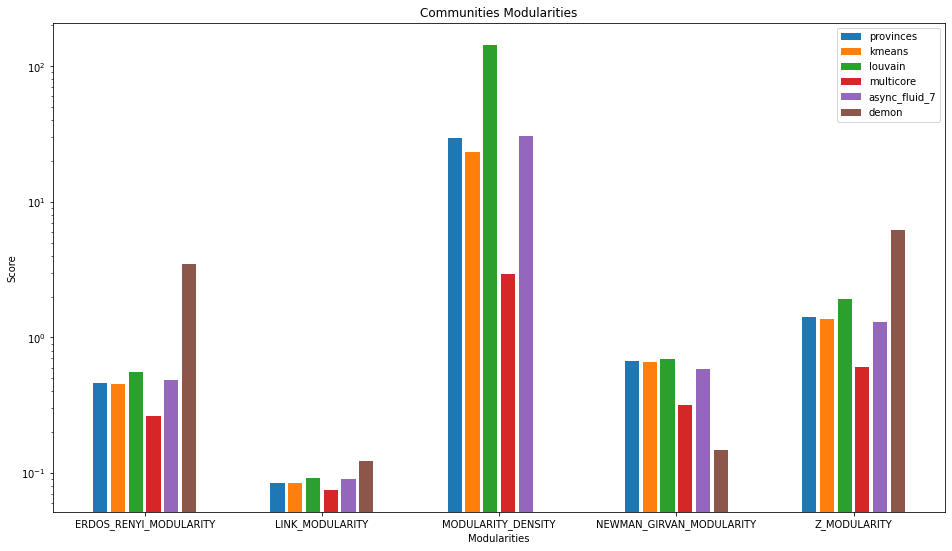

In [71]:
bins = [i for i in range(len(mdf[bestPartitions].index))]
width = 0.1
barwidth = 0.08

plt.figure(figsize=(16,9))

for i, partition in enumerate(bestPartitions):
    pos = np.array(bins) - width*2.5+width*i
    heights = np.array(mdf[partition])
    #heights = (heights - min(heights)) / (max(heights) - min(heights))
    #§heights = (heights ) / (max(heights))
    print(np.shape(pos),np.shape(heights))
    print(heights)
    plt.bar(pos,heights,barwidth,label=partition)
    

plt.title("Communities Modularities")
plt.ylabel("Score")
plt.xlabel("Modularities")
plt.xticks(bins,labels=[modularity for  modularity in mdf[bestPartitions].index])

plt.yscale('log')

plt.legend(bestPartitions)
plt.show()

provinces
(5,) (5,)
[ 0.45958468  0.08482568 29.42434661  0.66617648  1.42381227]
kmeans
(5,) (5,)
[ 0.45187097  0.08448797 23.13276599  0.66193836  1.36414827]
louvain
(5,) (5,)
[5.54352090e-01 9.26786736e-02 1.43556975e+02 6.89314565e-01
 1.91233168e+00]
multicore
(5,) (5,)
[0.26334413 0.07541013 2.94309223 0.31482877 0.60650385]
async_fluid_7
(5,) (5,)
[ 0.4839903   0.09098273 30.81923683  0.58570791  1.29842589]
demon
(5,) (5,)
[ 3.45405424e+00  1.23408682e-01 -1.71356882e+03  1.47370306e-01
  6.14511460e+00]


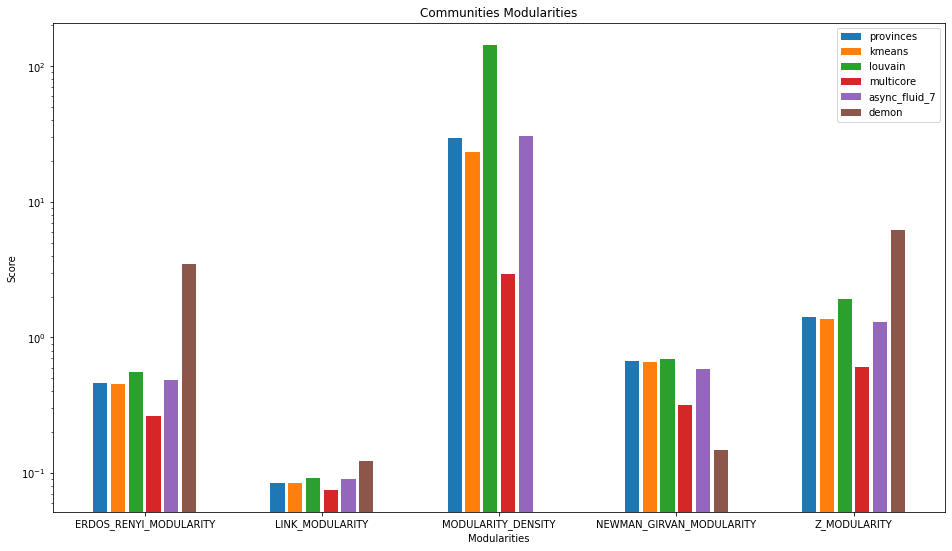

In [13]:
bins = [i for i in range(len(mdf[bestPartitions].index))]
width = 0.1
barwidth = 0.08

plt.figure(figsize=(16,9))

for i, partition in enumerate(bestPartitions):
    print(partition)
    pos = np.array(bins) - width*2.5+width*i
    heights = np.array(mdf[partition])
    #heights = (heights - min(heights)) / (max(heights) - min(heights))
    #§heights = (heights ) / (max(heights))
    print(np.shape(pos),np.shape(heights))
    print(heights)
    plt.bar(pos,heights,barwidth,label=partition)
    

plt.title("Communities Modularities")
plt.ylabel("Score")
plt.xlabel("Modularities")
plt.xticks(bins,labels=[modularity for  modularity in mdf[bestPartitions].index])

plt.yscale('log')

plt.legend(bestPartitions)
plt.show()

In [ ]:
[len(c) for c in communities.communities[:20]]

In [21]:
 for name, comm in data.items():
        if name in bestPartitions:
            
            print(np.average([len(c) for c in comm.communities]))

2143.285714285714
307.8772727272727
1500.3
714.4285714285714
3750.75
1500.3


In [19]:
 for name, comm in data.items():
        if name in bestPartitions:
            
            print(name,' -> ',len(comm.communities),'->',np.average([len(c) for c in comm.communities]))

async_fluid_7  ->  7 -> 2143.285714285714
demon  ->  220 -> 307.8772727272727
kmeans  ->  10 -> 1500.3
louvain  ->  21 -> 714.4285714285714
multicore  ->  4 -> 3750.75
provinces  ->  10 -> 1500.3


In [18]:
comm.communities

[[8192,
  8193,
  8203,
  8211,
  8229,
  8230,
  8233,
  8234,
  8235,
  43,
  8254,
  69,
  8268,
  8269,
  8270,
  8271,
  80,
  8273,
  8299,
  8301,
  8304,
  8307,
  8312,
  8330,
  140,
  8336,
  8338,
  8340,
  8341,
  8342,
  8343,
  153,
  8346,
  8347,
  8348,
  8349,
  157,
  8351,
  8352,
  8345,
  154,
  8350,
  8356,
  8358,
  8359,
  8360,
  8361,
  8362,
  8363,
  8364,
  8365,
  8366,
  8367,
  8368,
  8369,
  8370,
  8371,
  8372,
  8373,
  8374,
  8376,
  8377,
  8379,
  8380,
  8381,
  8382,
  8383,
  8384,
  8386,
  8387,
  8388,
  197,
  8390,
  8393,
  8394,
  8395,
  8396,
  8397,
  8398,
  8399,
  8400,
  8401,
  8402,
  8404,
  8405,
  8406,
  8408,
  8409,
  8410,
  8411,
  8413,
  8414,
  8415,
  8420,
  8421,
  8422,
  8423,
  231,
  8425,
  8426,
  8427,
  8428,
  245,
  8438,
  8439,
  8440,
  8441,
  8442,
  8443,
  8445,
  8448,
  8449,
  8451,
  8453,
  8454,
  8455,
  8456,
  8457,
  8458,
  8459,
  8460,
  8465,
  8466,
  8467,
  8468,
  8469,
  847

In [6]:

import matplotlib
import matplotlib.pyplot as plt
def heatmap(data, row_labels, col_labels, ax=None,
            cbar_kw={}, cbarlabel="", **kwargs):
    """
    Create a heatmap from a numpy array and two lists of labels.

    Parameters
    ----------
    data
        A 2D numpy array of shape (N, M).
    row_labels
        A list or array of length N with the labels for the rows.
    col_labels
        A list or array of length M with the labels for the columns.
    ax
        A `matplotlib.axes.Axes` instance to which the heatmap is plotted.  If
        not provided, use current axes or create a new one.  Optional.
    cbar_kw
        A dictionary with arguments to `matplotlib.Figure.colorbar`.  Optional.
    cbarlabel
        The label for the colorbar.  Optional.
    **kwargs
        All other arguments are forwarded to `imshow`.
    """

    if not ax:
        ax = plt.gca()

    # Plot the heatmap
    im = ax.imshow(data, **kwargs)

    # Create colorbar
    cbar = ax.figure.colorbar(im, ax=ax, **cbar_kw)
    cbar.ax.set_ylabel(cbarlabel, rotation=-90, va="bottom")

    # We want to show all ticks...
    ax.set_xticks(np.arange(data.shape[1]))
    ax.set_yticks(np.arange(data.shape[0]))
    # ... and label them with the respective list entries.
    ax.set_xticklabels(col_labels)
    ax.set_yticklabels(row_labels)

    # Let the horizontal axes labeling appear on top.
    ax.tick_params(top=True, bottom=False,
                   labeltop=True, labelbottom=False)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=-30, ha="right",
             rotation_mode="anchor")

    # Turn spines off and create white grid.
    ax.spines[:].set_visible(False)

    ax.set_xticks(np.arange(data.shape[1]+1)-.5, minor=True)
    ax.set_yticks(np.arange(data.shape[0]+1)-.5, minor=True)
    ax.grid(which="minor", color="w", linestyle='-', linewidth=3)
    ax.tick_params(which="minor", bottom=False, left=False)

    return im, cbar


def annotate_heatmap(im, data=None, valfmt="{x:.2f}",
                     textcolors=("black", "white"),
                     threshold=None, **textkw):
    """
    A function to annotate a heatmap.

    Parameters
    ----------
    im
        The AxesImage to be labeled.
    data
        Data used to annotate.  If None, the image's data is used.  Optional.
    valfmt
        The format of the annotations inside the heatmap.  This should either
        use the string format method, e.g. "$ {x:.2f}", or be a
        `matplotlib.ticker.Formatter`.  Optional.
    textcolors
        A pair of colors.  The first is used for values below a threshold,
        the second for those above.  Optional.
    threshold
        Value in data units according to which the colors from textcolors are
        applied.  If None (the default) uses the middle of the colormap as
        separation.  Optional.
    **kwargs
        All other arguments are forwarded to each call to `text` used to create
        the text labels.
    """

    if not isinstance(data, (list, np.ndarray)):
        data = im.get_array()

    # Normalize the threshold to the images color range.
    if threshold is not None:
        threshold = im.norm(threshold)
    else:
        threshold = im.norm(data.max())/2.

    # Set default alignment to center, but allow it to be
    # overwritten by textkw.
    kw = dict(horizontalalignment="center",
              verticalalignment="center")
    kw.update(textkw)

    # Get the formatter in case a string is supplied
    if isinstance(valfmt, str):
        valfmt = matplotlib.ticker.StrMethodFormatter(valfmt)

    # Loop over the data and create a `Text` for each "pixel".
    # Change the text's color depending on the data.
    texts = []
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            kw.update(color=textcolors[int(im.norm(data[i, j]) > threshold)])
            text = im.axes.text(j, i, valfmt(data[i, j], None), **kw)
            texts.append(text)

    return texts

In [7]:
 for name, comm in data.items():
        if name in bestPartitions:
            
            print(name,evaluation.nf1(comm, data['provinces']).score)

async_fluid_7 0.13877551020408166
demon 0.000524759793052476
kmeans 0.42560000000000003
louvain 0.11974675324675323
multicore 0.028500000000000004
provinces 1.0


In [20]:
 for name, comm in data.items():
        if name in bestPartitions:
            
            print( evaluation.nf1(comm, data['provinces']).score)

0.13877551020408166
0.000524759793052476
0.42560000000000003
0.11974675324675323
0.028500000000000004
1.0


In [5]:
bestPartitions = ['provinces', 'kmeans', 'louvain', 'multicore', 'async_fluid_7','demon']

In [ ]:
omegamatrix = [[] for _ in bestPartitions]
for i,c1 in enumerate(bestPartitions):
    for j, c2 in enumerate(bestPartitions):
        voimatrix[i].append(evaluation.omega(data[c1], data[c2]).score)

In [ ]:
df = pd.DataFrame( omegamatrix,index = bestPartitions, columns = bestPartitions)
df

In [ ]:
bestPartitions = ['provinces', 'kmeans', 'louvain', 'multicore', 'async_fluid_7']

In [ ]:
voigamatrix = [[] for _ in bestPartitions]
for i,c1 in enumerate(bestPartitions):
    for j, c2 in enumerate(bestPartitions):
        voimatrix[i].append(evaluation.variation_of_information(data[c1], data[c2]).score)

In [ ]:
df = pd.DataFrame( voigamatrix,index = bestPartitions, columns = bestPartitions)
df

In [66]:
bestPartitions = ['provinces', 'kmeans', 'louvain', 'multicore', 'async_fluid_7','demon']

In [55]:
nf1matrix = [[] for _ in bestPartitions]
for i,c1 in enumerate(bestPartitions):
    for j, c2 in enumerate(bestPartitions):
        nf1matrix[i].append(evaluation.nf1(data[c1], data[c2]).score)

In [67]:
df = pd.DataFrame( nf1matrix,index = bestPartitions, columns = bestPartitions)
df

,provinces,kmeans,louvain,multicore,async_fluid_7,demon
provinces,1.000000,0.315070,0.182248,0.098800,0.132500,0.008542
kmeans,0.425600,1.000000,0.280000,0.092000,0.253400,0.009278
louvain,0.119747,0.151299,1.000000,0.022771,0.079206,0.029259
multicore,0.028500,0.032250,0.036429,1.000000,0.109286,0.003409
async_fluid_7,0.138776,0.206449,0.110554,0.158367,1.000000,0.006500
demon,0.000525,0.000514,0.001438,0.000118,0.000333,0.104111


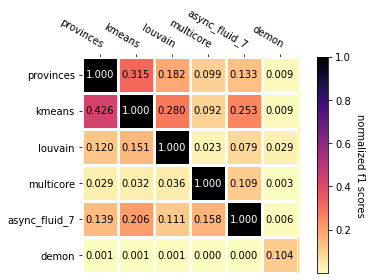

In [68]:
fig, ax = plt.subplots()

im, cbar = heatmap(df.values, partitions, partitions, ax=ax,
                   cmap="magma_r", cbarlabel="normalized f1 scores")
texts = annotate_heatmap(im, valfmt="{x:.3f}")

fig.tight_layout()
plt.show()

In [60]:
bestPartitions = ['provinces', 'kmeans', 'louvain', 'multicore', 'async_fluid_7']

In [61]:
amimatrix = [[] for _ in bestPartitions]
for i,c1 in enumerate(bestPartitions):
    for j, c2 in enumerate(bestPartitions):
        amimatrix[i].append(evaluation.adjusted_mutual_information(data[c1], data[c2]).score)

In [62]:
df = pd.DataFrame( amimatrix,index = bestPartitions, columns = bestPartitions)
df

,provinces,kmeans,louvain,multicore,async_fluid_7
provinces,1.000000,0.711466,0.428371,0.089583,0.217371
kmeans,0.711466,1.000000,0.395237,0.085389,0.214331
louvain,0.428371,0.395237,1.000000,0.101150,0.287299
multicore,0.089583,0.085389,0.101150,1.000000,0.057529
async_fluid_7,0.217371,0.214331,0.287299,0.057529,1.000000


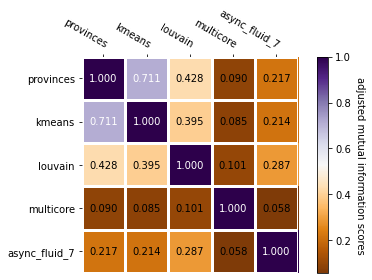

In [64]:
fig, ax = plt.subplots()

im, cbar = heatmap(df.values, bestPartitions, bestPartitions, ax=ax,
                   cmap="PuOr", cbarlabel="adjusted mutual information scores")
texts = annotate_heatmap(im, valfmt="{x:.3f}")

fig.tight_layout()
plt.show()

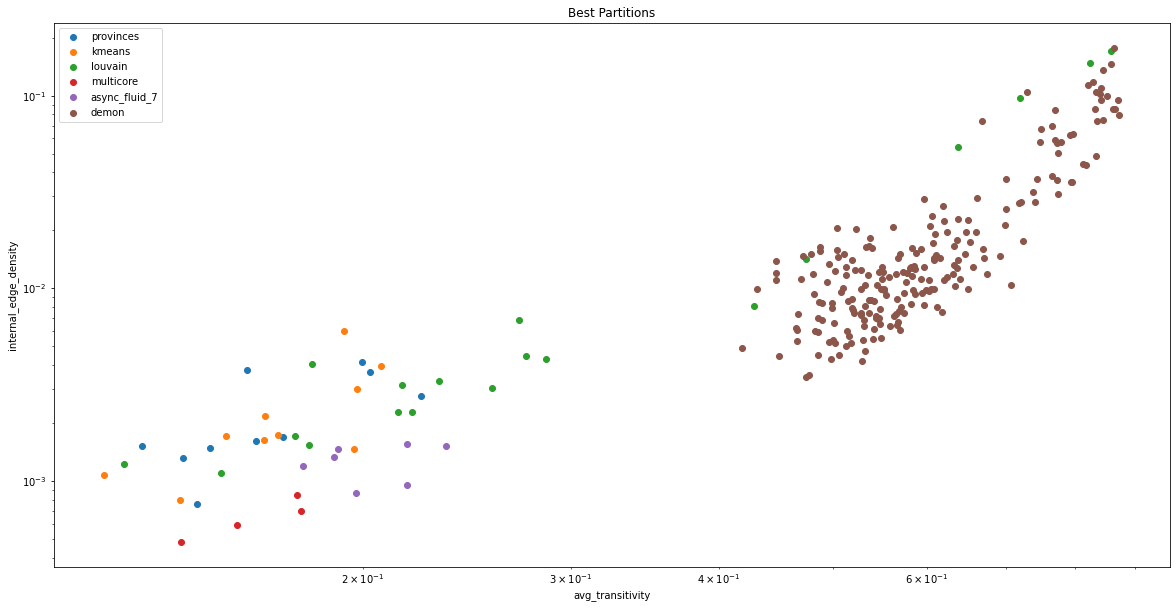

In [74]:
bestPartitions = ['provinces', 'kmeans', 'louvain','multicore','async_fluid_7','demon']
bestp = ['provinces', 'kmeans']

plt.figure(figsize=(10,5))
for partition in bestPartitions:
    avg_transitivity = evaluation.avg_transitivity(G,data[partition],summary=False)
    internal_edge_density= evaluation.internal_edge_density(G,data[partition],summary=False)
    plt.scatter(avg_transitivity,internal_edge_density)
  
plt.title('Best Partitions')
plt.xlabel('avg_transitivity')
plt.ylabel('internal_edge_density')
plt.xscale('log')
plt.yscale('log')
plt.legend([p for p in bestPartitions],loc=2)
plt.show()

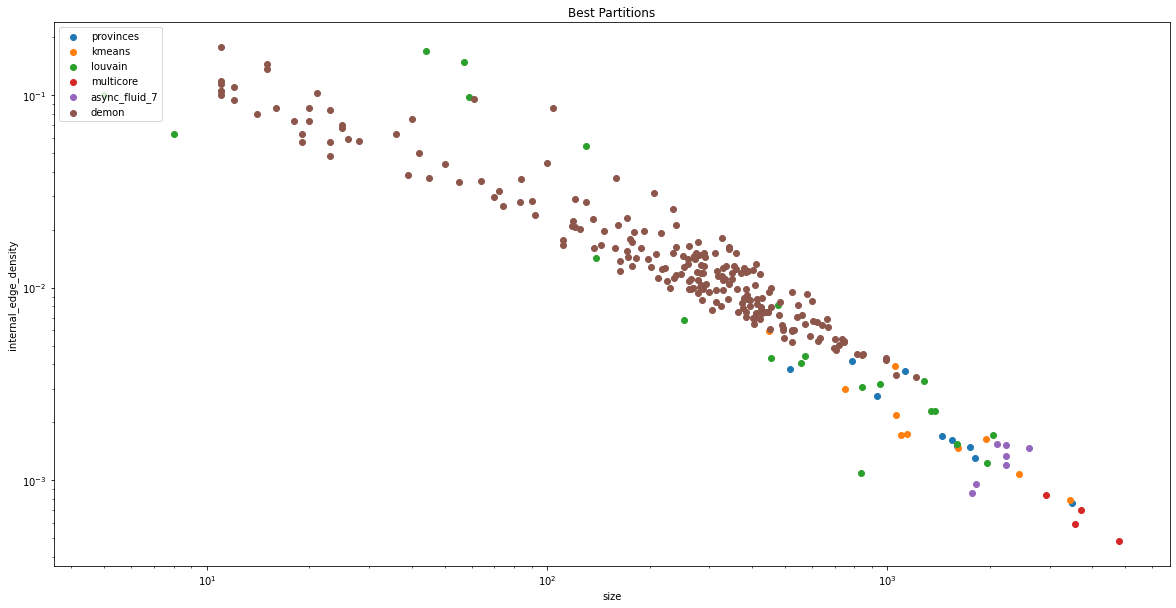

In [75]:
bestPartitions = ['provinces', 'kmeans', 'louvain','multicore','async_fluid_7','demon']
bestp = ['provinces', 'kmeans']

plt.figure(figsize=(20,10))
for partition in bestPartitions:
    size = evaluation.size(G,data[partition],summary=False)
    internal_edge_density= evaluation.internal_edge_density(G,data[partition],summary=False)
    plt.scatter(size,internal_edge_density)
  
plt.title('Best Partitions')
plt.xlabel('size')
plt.ylabel('internal_edge_density')
plt.xscale('log')
plt.yscale('log')
plt.legend([p for p in bestPartitions],loc=2)
plt.show()

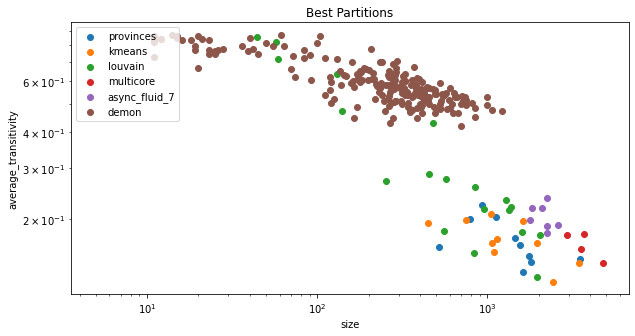

In [5]:
bestPartitions = ['provinces', 'kmeans', 'louvain','multicore','async_fluid_7','demon']
bestp = ['provinces', 'kmeans']

plt.figure(figsize=(10,5))
for partition in bestPartitions:
    size = evaluation.size(G,data[partition],summary=False)
    avg_transitivity = evaluation.avg_transitivity(G,data[partition],summary=False)
    plt.scatter(size,avg_transitivity)
  
plt.title('Best Partitions')
plt.xlabel('size')
plt.ylabel('average_transitivity')
plt.xscale('log')
plt.yscale('log')
plt.legend([p for p in bestPartitions],loc=2)
plt.show()

In [19]:
evaluation.avg_transitivity(G,data['louvain'],summary=False)

[0.12497936572919267,
 0.14804413715273382,
 0.15881921693632464,
 0.19723119987542714,
 0.17156050182687127,
 0.20734255270578,
 0.22385687741030116,
 0.18829226246544156,
 0.1749706407739214,
 0.3415764597106315,
 0.20592209164842623,
 0.41318011770827207,
 0.0,
 0.0,
 0.0,
 0.27777777777777773,
 0.0]

In [39]:
fdf.to_csv('../data/fitnessMeasures.csv')

## DEMON analysis

In [51]:
print(evaluation.nf1(demon,cuisines).score)
print(evaluation.nf1(cuisines,demon).score)
print(evaluation.overlapping_normalized_mutual_information_LFK(demon,cuisines).score)
print(evaluation.overlapping_normalized_mutual_information_LFK(cuisines,demon).score)

5.227687609943909e-05
0.00346661901218127
0.0013761792782406301
0.0013761792782406301


In [50]:
print(evaluation.overlapping_normalized_mutual_information_MGH(cuisines,demon).score)

0.0007775851157653268


In [7]:
bestPartitions = ['provinces', 'kmeans', 'louvain','async_fluid7','demon']

In [67]:
from cdlib import ensemble

epsilon = ensemble.Parameter(name="epsilon", start=0.1, end=0.95, step=0.05)
min_com_size = ensemble.Parameter(name="min_com_size", start=7, end=30, step=3)
communities, scoring = ensemble.random_search(graph=G, method=cd.demon,
                                                   parameters=[epsilon, min_com_size],
                                                     quality_score=evaluation.modularity_density,

                                              instances=20, aggregate=max)

In [92]:
print(len(communities.communities), [len(c) for c in communities.communities[:30]])
scoring


88 [2762, 2686, 2192, 1937, 1795, 1626, 1508, 1451, 1311, 1176, 1094, 1038, 1034, 1016, 943, 920, 888, 874, 861, 846, 805, 785, 783, 753, 722, 718, 692, 684, 676, 670]


FitnessResult(min=None, max=None, score=-445.968981485347, std=None)

In [73]:

readwrite.write_community_json(communities,'../data/communities/best_demon.json')

In [85]:
scores = dict()
for evaluation_function in evaluation_functions:
    f_name = str(evaluation_function).split(' ')[1].upper()
    print(f_name,end= ' -> ')
    try: 
        ev = evaluation_function(G,communities)
        print(ev)
        scores[f_name] = ev.score

    except Exception as e: 
        print(e) 
        scores[f_name] = np.nan

AVG_EMBEDDEDNESS -> FitnessResult(min=0.20256094861324986, max=0.5293011842248415, score=0.42573216234039146, std=0.053378570916549094)
AVERAGE_INTERNAL_DEGREE -> FitnessResult(min=4.9523809523809526, max=17.382151029748282, score=13.531294903840006, std=2.124119347791685)
AVG_TRANSITIVITY -> FitnessResult(min=0.3263208649727251, max=0.8034834519295105, score=0.4744669779685644, std=0.08643821173053093)
CONDUCTANCE -> FitnessResult(min=0.47265839129746257, max=0.8095238095238095, score=0.5801372803667318, std=0.05688571332691644)
CUT_RATIO -> FitnessResult(min=0.0009768355644903368, max=0.0014476947371216916, score=0.0012526505189665838, std=9.074001478958819e-05)
EDGES_INSIDE -> FitnessResult(min=52, max=21645, score=4677.943181818182, std=4179.5247483142975)
EXPANSION -> FitnessResult(min=14.445644080416978, max=21.71252566735113, score=18.599124238900767, std=1.647192451559863)
FRACTION_OVER_MEDIAN_DEGREE -> FitnessResult(min=0.36363636363636365, max=0.5, score=0.4752432473068915, s

/home/ec2-user/.local/lib/python3.7/site-packages/cdlib/evaluation/fitness.py:769: RuntimeWarning: invalid value encountered in log2
  sp = m * (q * np.log(q / qa) + (1 - q) * np.log2((1 - q) / (1 - qa)))


FitnessResult(min=None, max=None, score=nan, std=None)
TRIANGLE_PARTICIPATION_RATIO -> FitnessResult(min=1.0, max=1.0, score=1.0, std=0.0)


In [86]:
fdf['best_demon'] = scores.values()

fdf[bestPartitions]

,provinces,kmeans,louvain,async_fluid7,demon,best_demon
AVG_EMBEDDEDNESS,0.622747,0.598133,0.633786,0.633703,4.039551e-01,4.257322e-01
AVERAGE_INTERNAL_DEGREE,12.457666,11.545680,9.221981,12.397301,1.220136e+01,1.353129e+01
AVG_TRANSITIVITY,0.149638,0.161472,0.166680,0.171494,4.917599e-01,4.744670e-01
CONDUCTANCE,0.388756,0.425070,0.398693,0.372631,6.077663e-01,5.801373e-01
CUT_RATIO,0.000551,0.000599,0.000378,0.000547,1.261656e-03,1.252651e-03
EDGES_INSIDE,9481.100000,9173.700000,5837.882353,13742.285714,3.858889e+03,4.677943e+03
EXPANSION,7.682342,8.378986,5.398592,7.262762,1.879550e+01,1.859912e+01
FRACTION_OVER_MEDIAN_DEGREE,0.480592,0.483667,0.413376,0.477071,4.708639e-01,4.752432e-01
HUB_DOMINANCE,0.039398,0.038286,NaN,0.024917,1.487641e-01,1.149746e-01
INTERNAL_EDGE_DENSITY,0.002596,0.002501,0.015976,0.001408,1.314525e-02,9.697659e-03


In [87]:
scores = dict()
for evaluation_function in all_modularities:
    f_name = str(evaluation_function).split(' ')[1].upper()
    print(f_name,end= ' -> ')
    try: 
        ev = evaluation_function(G,communities)
        print(ev)
        scores[f_name] = ev.score

    except Exception as e: 
        print(e) 
        scores[f_name] = np.nan

ERDOS_RENYI_MODULARITY -> FitnessResult(min=None, max=None, score=2.450397680535787, std=None)
LINK_MODULARITY -> FitnessResult(min=None, max=None, score=0.09787545054568741, std=None)
MODULARITY_DENSITY -> FitnessResult(min=None, max=None, score=-445.968981485347, std=None)
NEWMAN_GIRVAN_MODULARITY -> FitnessResult(min=None, max=None, score=0.20685187983342135, std=None)
Z_MODULARITY -> FitnessResult(min=None, max=None, score=4.317548809209999, std=None)


In [88]:
mdf['best_demon'] = scores.values()
mdf[bestPartitions]

,provinces,kmeans,louvain,async_fluid7,demon,best_demon
ERDOS_RENYI_MODULARITY,0.494412,0.468434,0.539173,0.487919,3.115386,2.450398
LINK_MODULARITY,0.090054,0.087134,0.094264,0.091369,0.117237,0.097875
MODULARITY_DENSITY,47.753240,31.666932,64.997619,35.941770,-890.209844,-445.968981
NEWMAN_GIRVAN_MODULARITY,0.527735,0.502586,0.634118,0.580483,0.230205,0.206852
Z_MODULARITY,1.525067,1.405646,1.714450,1.382000,6.529580,4.317549


In [8]:
def plot_kcentral(G,dictionary,k=10):
    sorted_dictionary =  sorted(dictionary.items(), key=lambda x: x[1],reverse = True)
    nodes, values = zip(*sorted_dictionary)
    nodes = nodes[:k]
    values = values[:k]
    names = [G.nodes[node]['name'] for node in nodes]
    
    plt.figure(figsize=(20,5))
    plt.bar(names, values, color=sns.color_palette('ocean',k))
    plt.xticks(rotation=25)

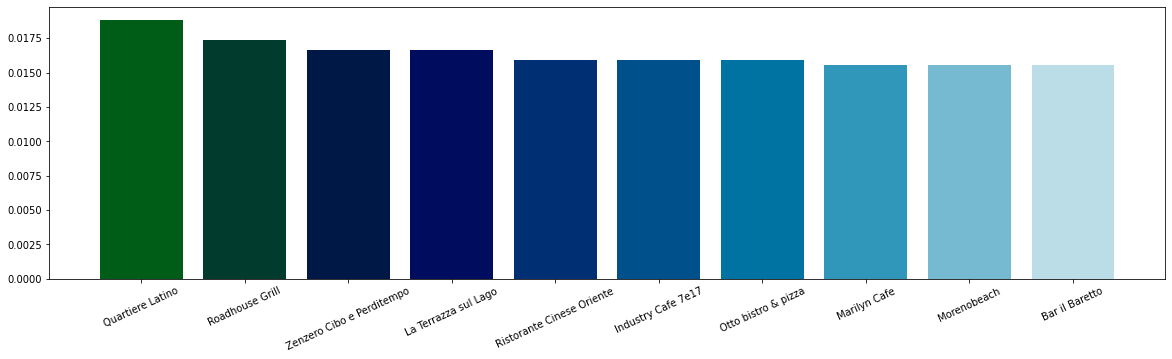

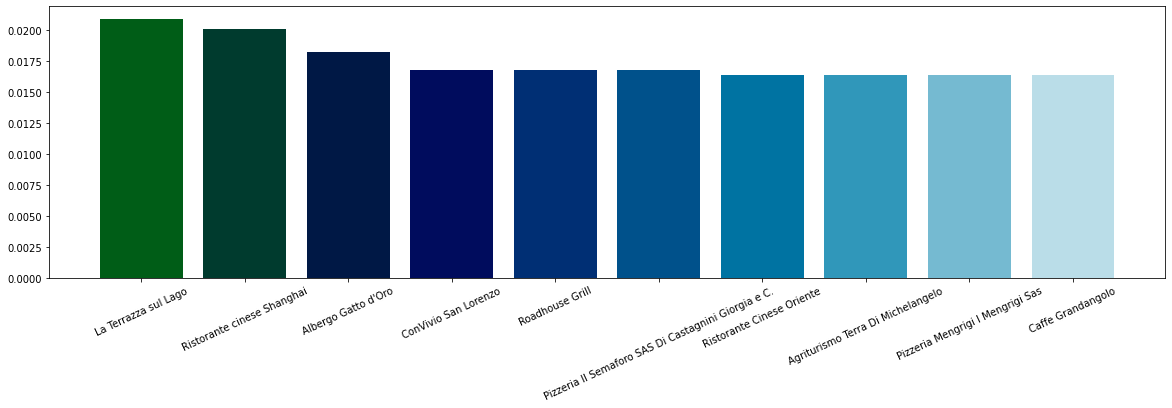

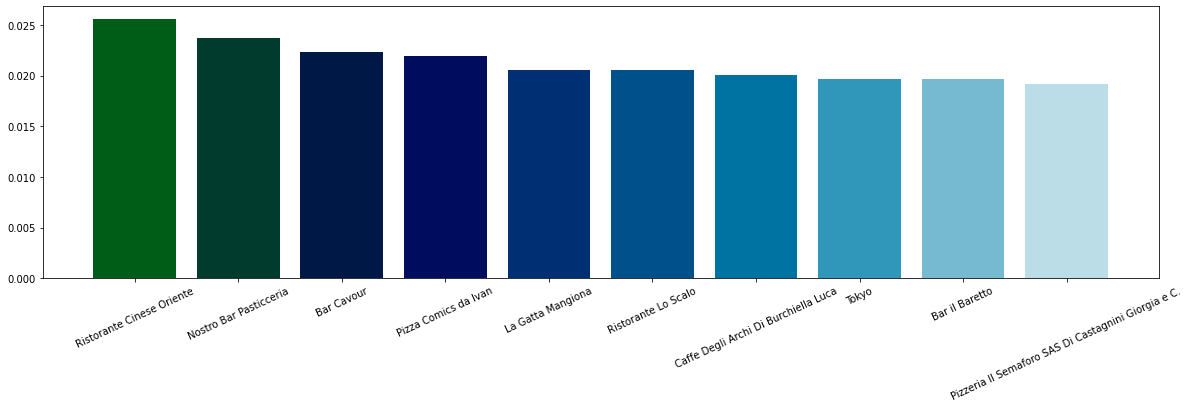

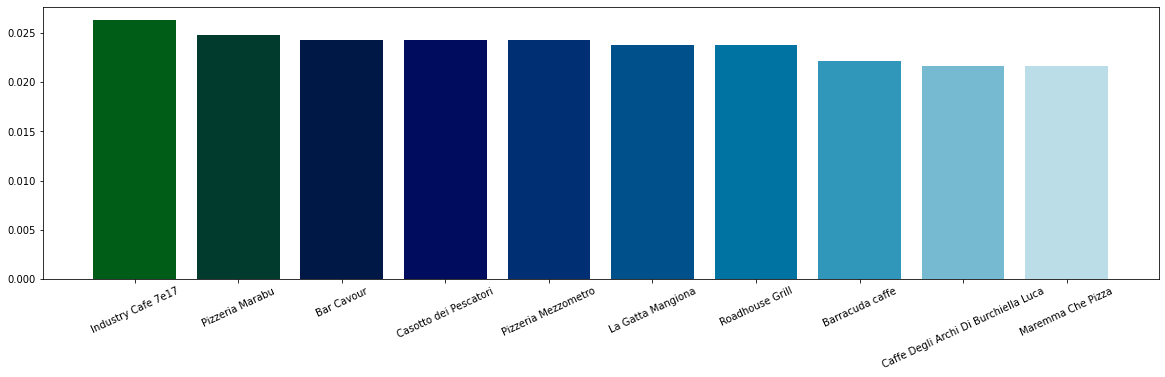

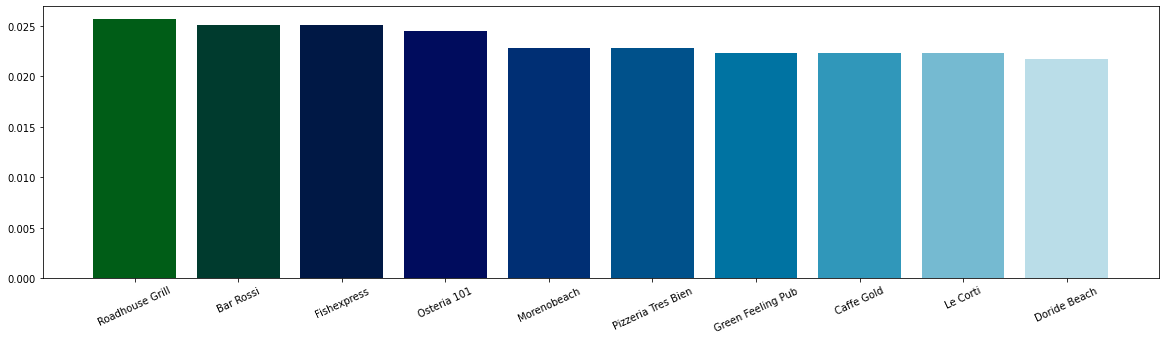

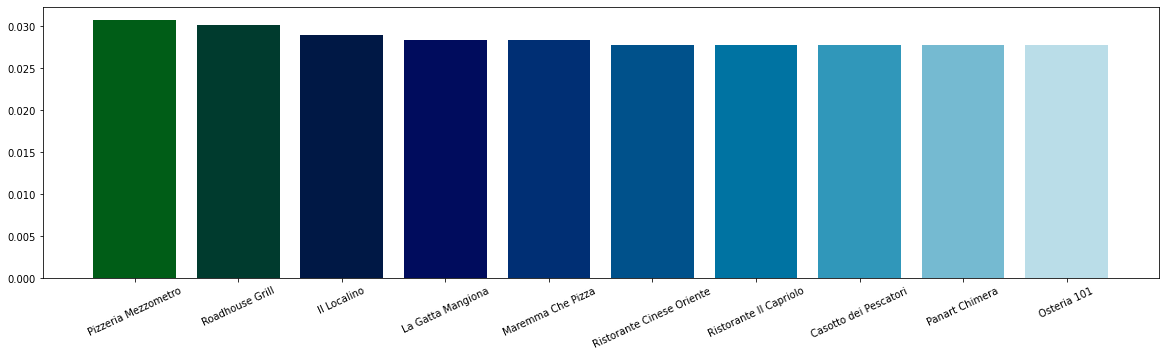

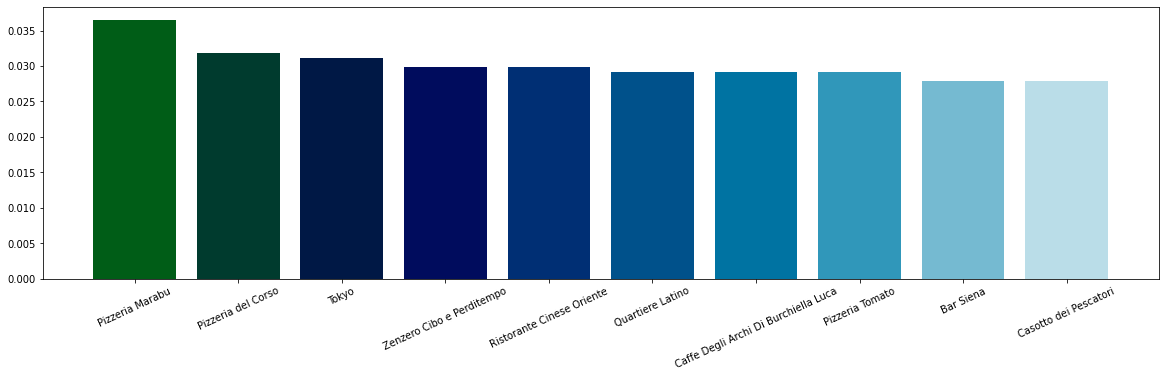

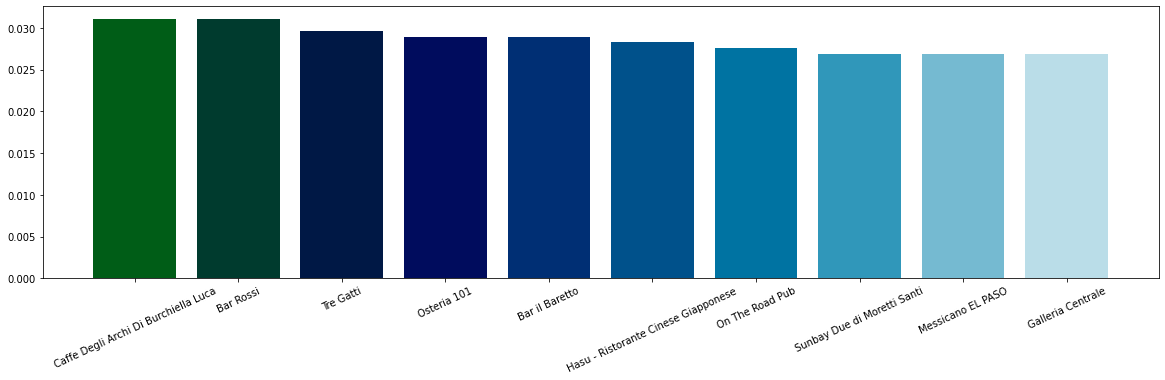

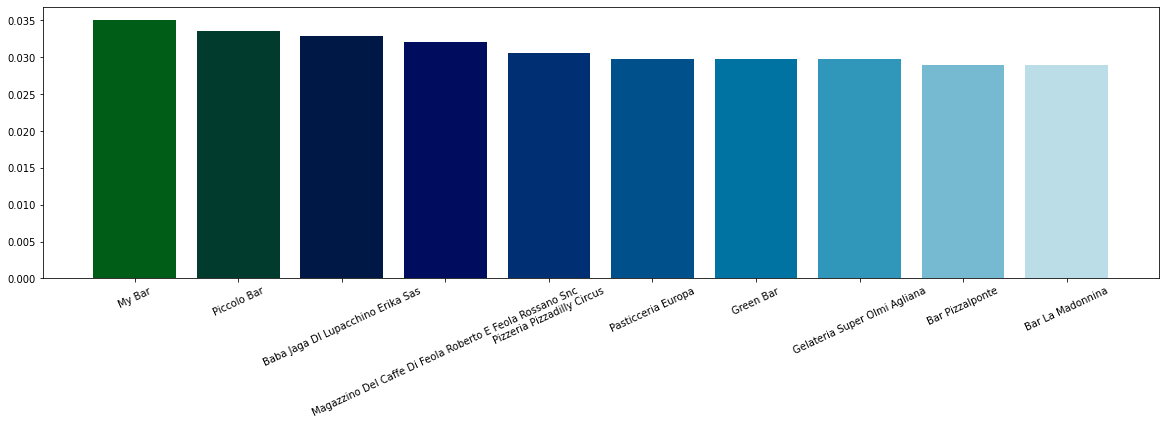

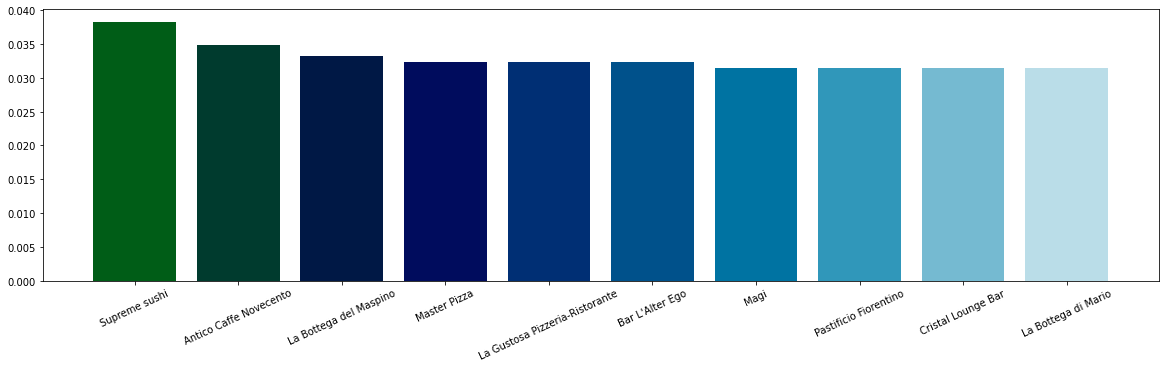

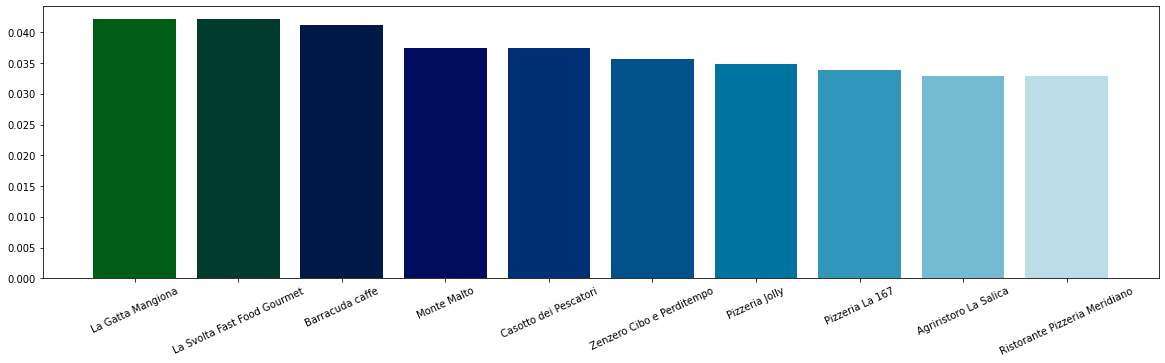

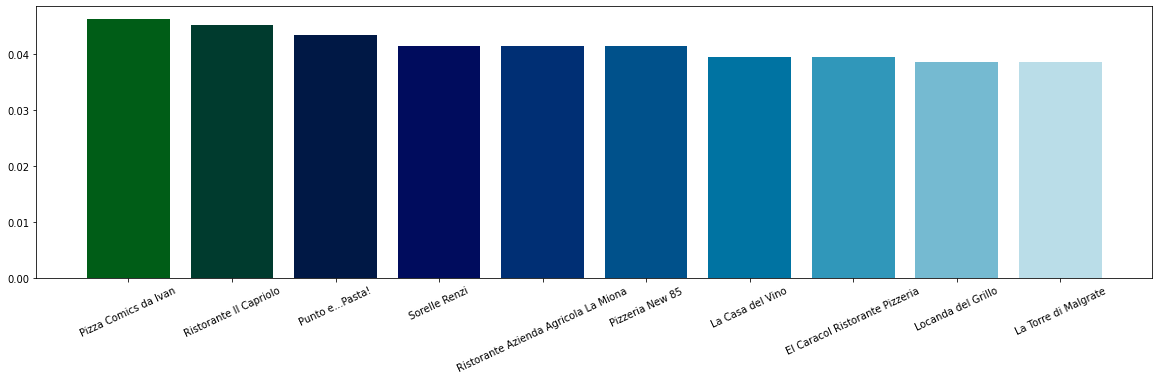

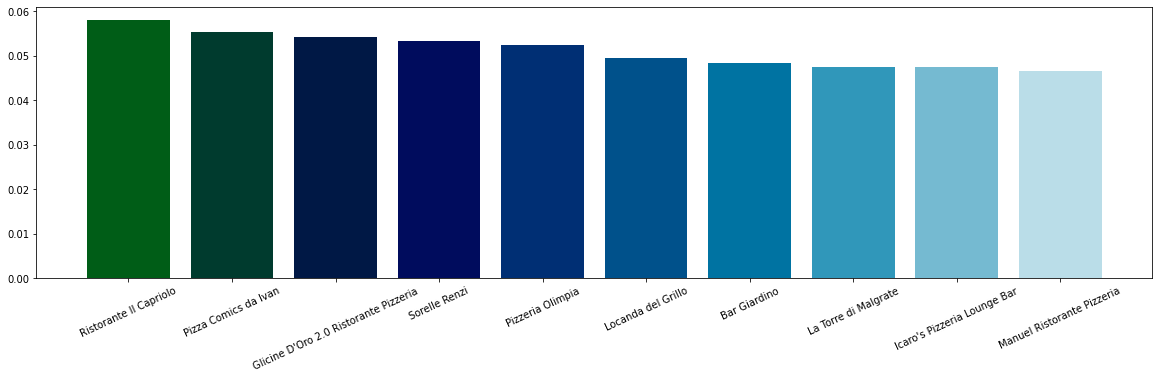

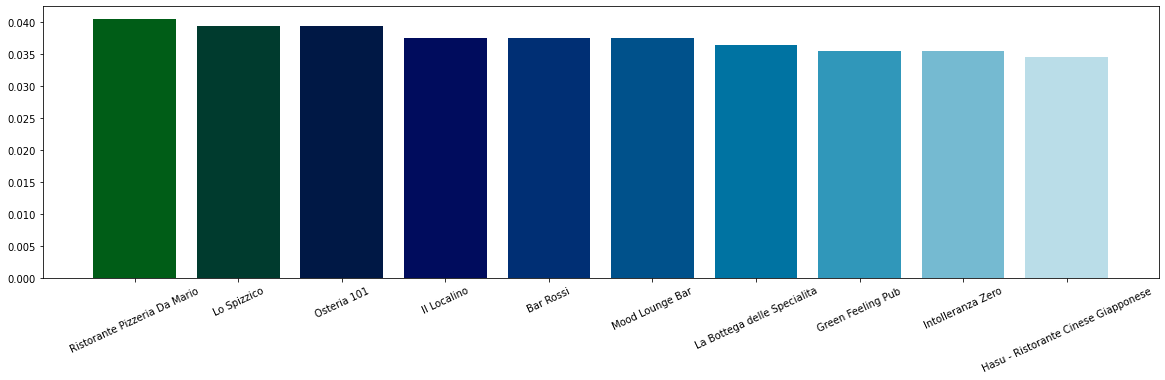

In [13]:
for c in data['best_demon'].communities:
    if len(c) <1000: continue 
    C = G.subgraph(c).copy()
    degree_centrality = nx.degree_centrality(C)
    plot_kcentral(C,degree_centrality,10)

In [8]:
df

NameError: name 'df' is not defined

### Louvain  Analysis


In [9]:
print(len(data['louvain'].communities),[len(c) for c in data['louvain'].communities])


17 [2463, 2409, 1894, 1847, 1839, 1336, 1225, 877, 537, 455, 389, 165, 20, 11, 11, 6, 1]


In [10]:
for node in G.nodes:
    G.nodes[node]['name'] = df.loc[node,'name']

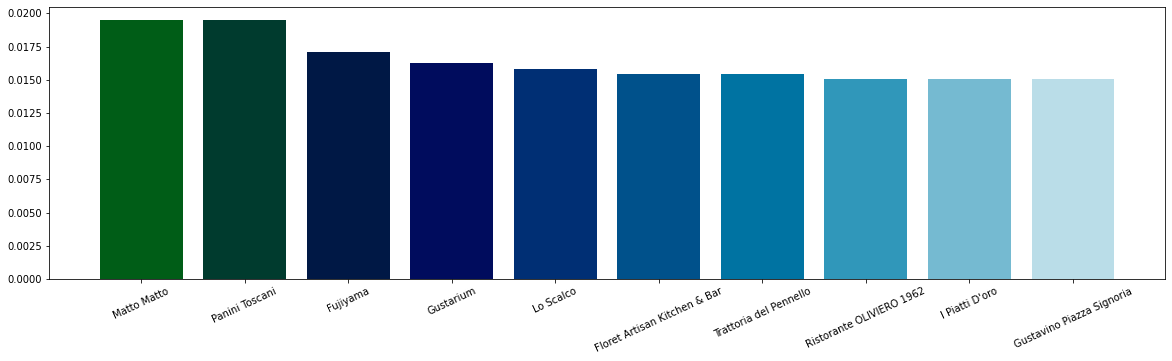

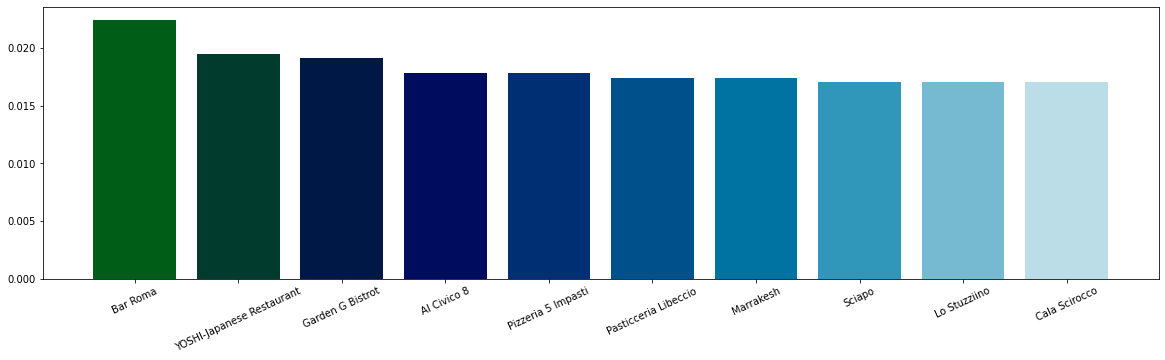

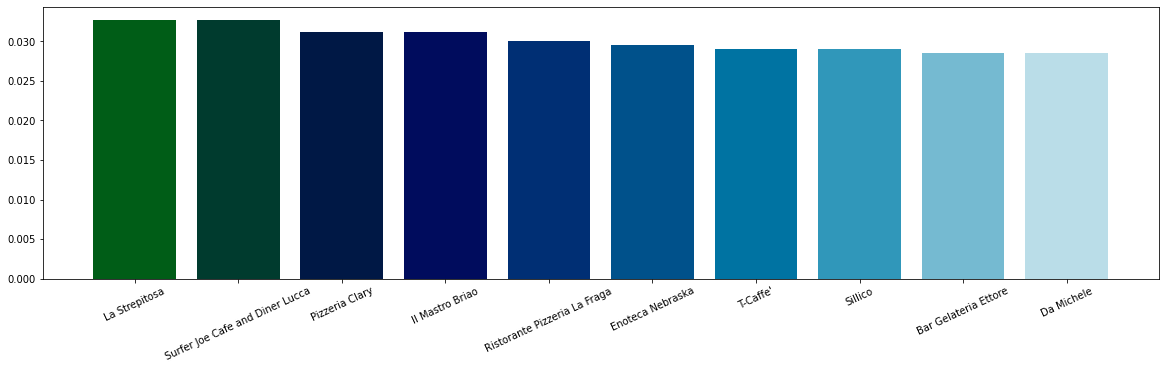

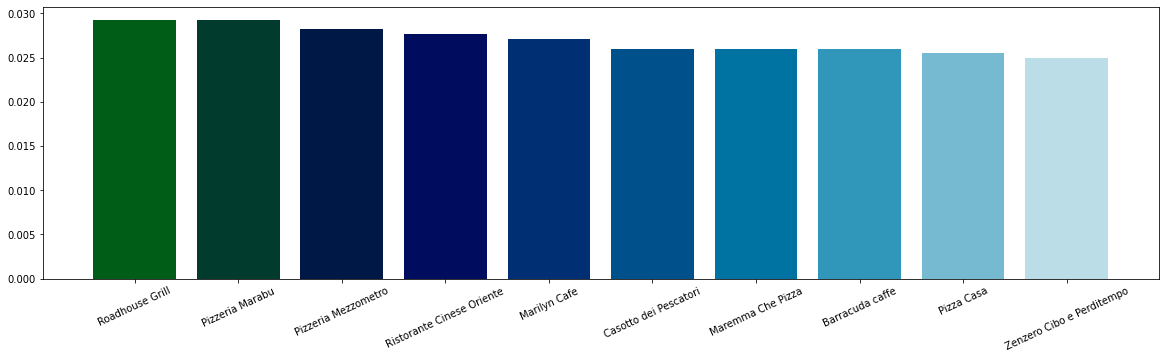

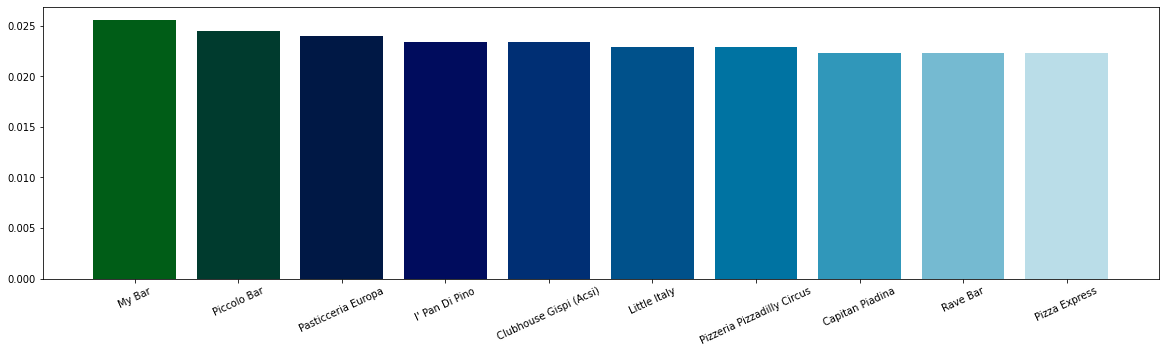

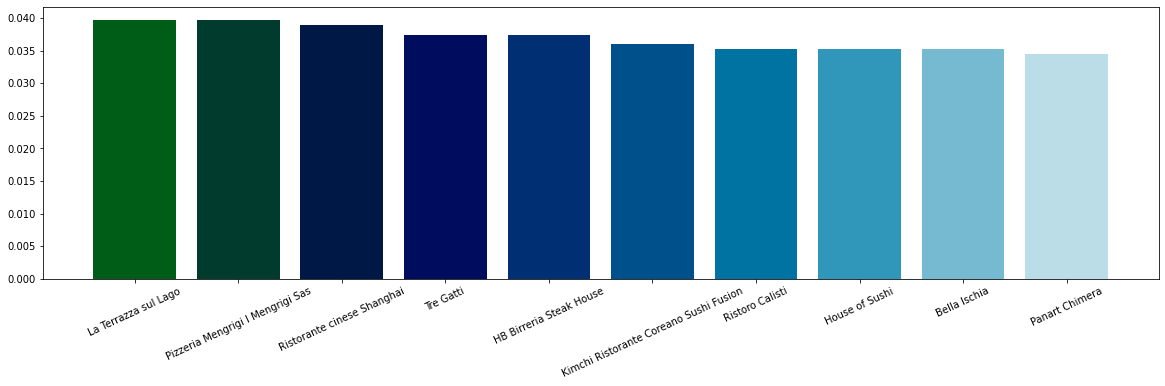

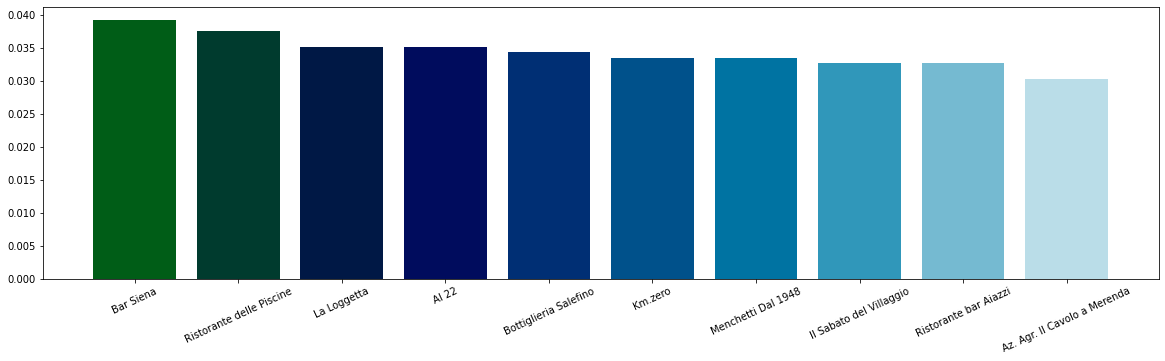

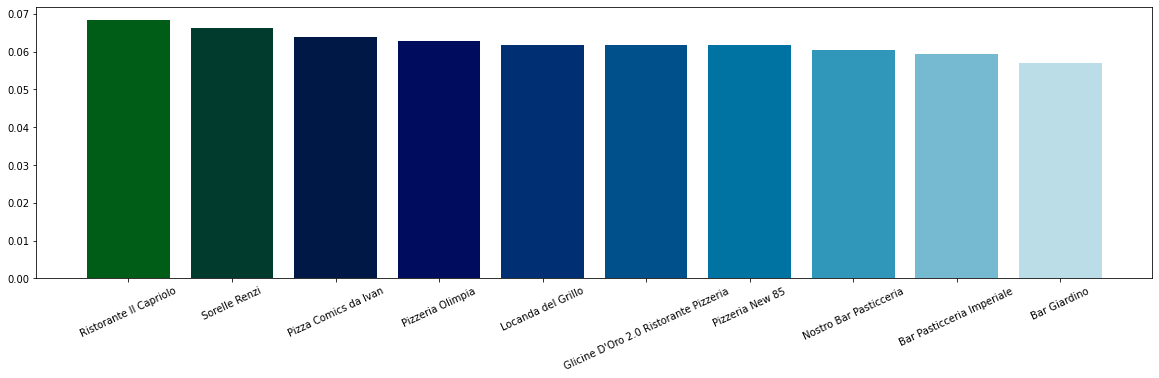

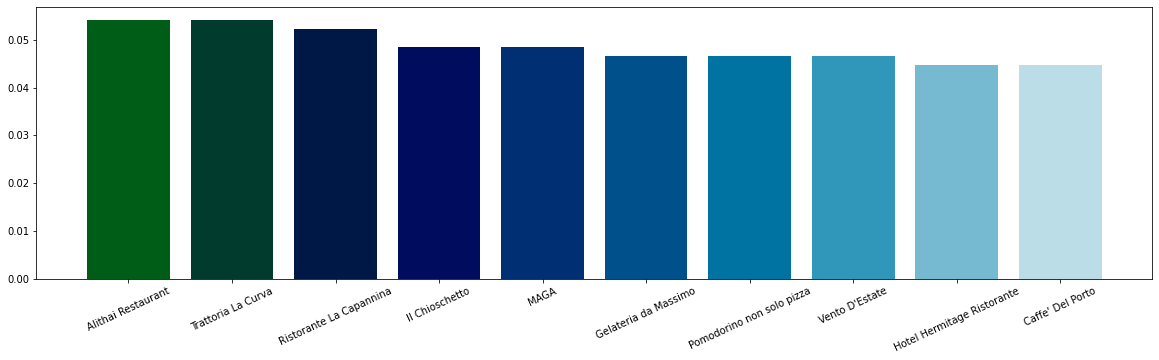

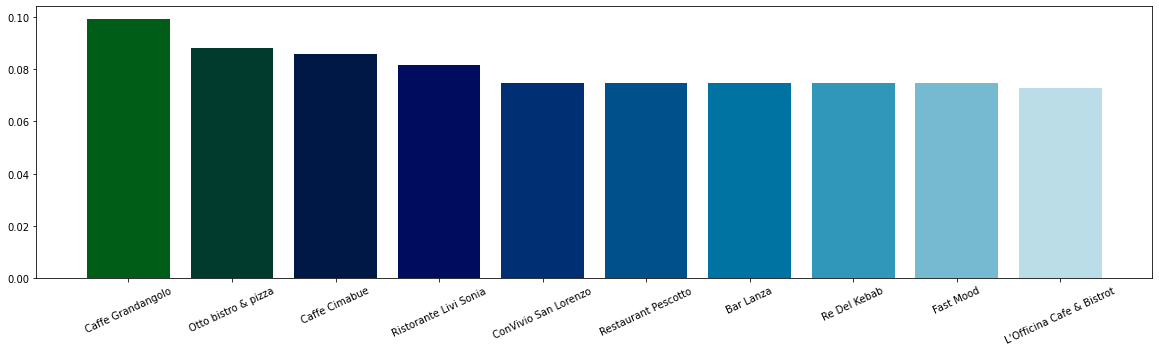

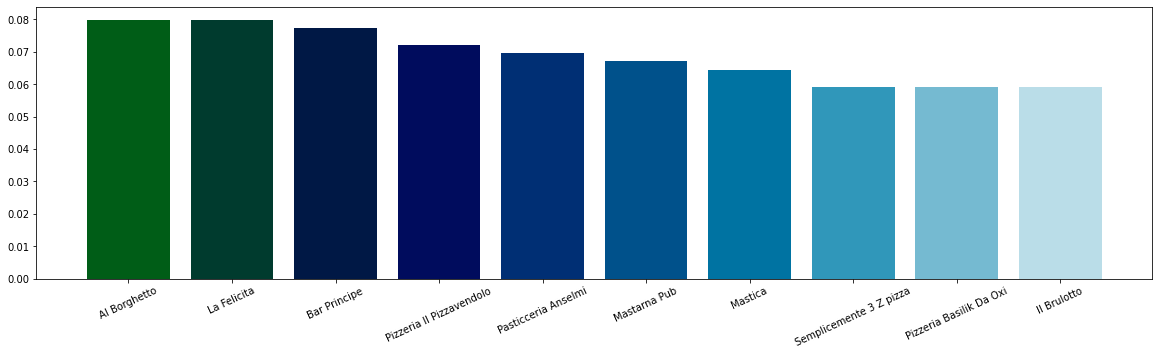

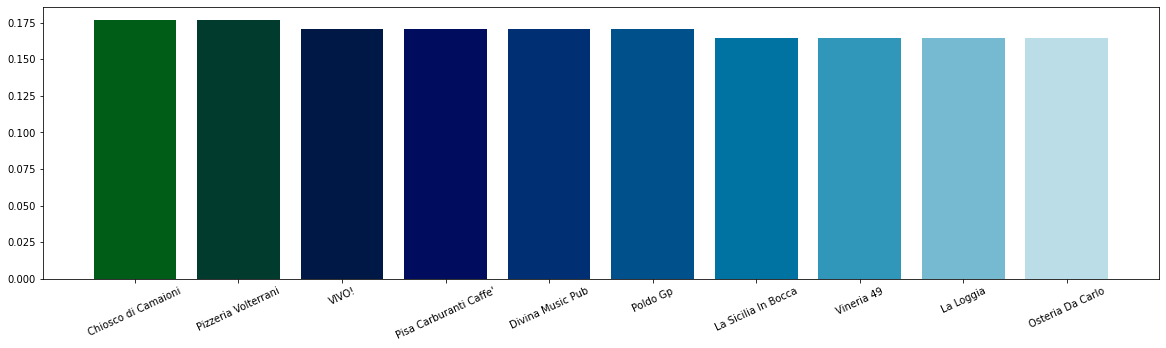

In [12]:
for c in data['louvain'].communities:
    if len(c) <100: continue 
    C = G.subgraph(c).copy()
    degree_centrality = nx.degree_centrality(C)
    plot_kcentral(C,degree_centrality,10)

In [14]:
for i, l in enumerate(data['louvain'].communities):
    for node in l:
        df.loc[node,'louvain'] = i 

In [15]:
pd.crosstab(df['province'],df['louvain'])

louvain,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0,13.0,14.0,15.0,16.0
province,,,,,,,,,,,,,,,,,
arezzo,10,10,8,27,10,1014,21,1,7,7,6,3,0,0,0,0,0
florence,2014,254,50,99,324,189,119,38,27,362,57,91,7,8,0,6,0
grosseto,29,28,15,1379,24,25,23,5,10,14,14,5,0,0,0,0,0
livorno,57,824,32,34,76,30,19,10,439,12,249,11,2,0,0,0,1
lucca,25,73,1643,32,56,20,16,42,16,6,14,4,0,0,2,0,0
massacarrara,7,12,19,5,12,0,7,727,0,0,1,1,0,0,0,0,0
pisa,138,1145,84,46,31,11,63,27,12,34,17,19,11,0,9,0,0
pistoia,26,33,20,17,822,2,11,5,6,11,11,3,0,0,0,0,0
prato,18,4,5,8,464,2,6,3,6,2,5,10,0,2,0,0,0


In [16]:
for i, l in enumerate(data['async_fluid10'].communities):
    for node in l:
        df.loc[node,'async_fluid10'] = i 

In [17]:
pd.crosstab(df['province'],df['async_fluid10'])

async_fluid10,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0
province,,,,,,,,,,
arezzo,10,9,8,216,26,20,17,421,357,40
florence,68,214,319,955,292,247,666,444,274,166
grosseto,8,25,819,56,51,327,36,21,41,187
livorno,50,67,164,62,157,125,104,114,352,601
lucca,1508,69,38,32,53,32,35,26,64,92
massacarrara,22,199,4,4,527,8,13,6,2,6
pisa,51,817,51,88,82,73,66,162,77,180
pistoia,18,93,14,27,108,15,431,80,167,14
prato,19,66,141,26,28,10,48,129,55,13


## Multicore Analysis

In [93]:
from cdlib import ensemble

alfa = ensemble.Parameter(name="alfa", start=0.55, end=0.85, step=0.05)
minsize = ensemble.Parameter(name="minsize", start=250, end=750, step=100)
communities, scoring = ensemble.random_search(graph=G, method=cd.multicore,
                                                   parameters=[alfa, minsize],
                                                     quality_score=evaluation.newman_girvan_modularity,

                                              instances=20, aggregate=max)

In [84]:
scoring


FitnessResult(min=None, max=None, score=18.215823501966273, std=None)

In [85]:
communities

In [92]:
[len(c) for c in communities.communities]

[15003]

## ASSIGNING COMMUNITIES

In [52]:
import os 
data = dict()


for f in os.listdir('../data/communitiesW'):
    if f[-5:] != '.json': continue
   
    name = f[:-5]
    
    communities = readwrite.read_community_json(f'../data/communitiesW/{f}')
    data[name] = communities
    print(name,' -> ',len(communities.communities),' -> ', [len(c) for c in communities.communities[:20]])

angel  ->  3  ->  [8076, 95, 10]
async_fluid_5  ->  5  ->  [3355, 3216, 3106, 2772, 2554]
async_fluid_7  ->  7  ->  [2615, 2236, 2232, 2227, 2093, 1823, 1777]
best_demon  ->  88  ->  [2762, 2686, 2192, 1937, 1795, 1626, 1508, 1451, 1311, 1176, 1094, 1038, 1034, 1016, 943, 920, 888, 874, 861, 846]
demon  ->  220  ->  [1216, 1057, 992, 989, 846, 844, 816, 747, 744, 735, 722, 707, 701, 699, 670, 665, 644, 632, 627, 620]
greedy_modularity  ->  67  ->  [11628, 2719, 225, 117, 40, 37, 20, 13, 11, 8, 7, 7, 6, 6, 5, 5, 5, 5, 5, 4]
kmeans  ->  10  ->  [3452, 2439, 1946, 1615, 1144, 1095, 1060, 1053, 751, 448]
label_propagation  ->  589  ->  [3830, 3614, 2306, 648, 572, 391, 271, 217, 176, 92, 75, 67, 58, 55, 53, 52, 47, 45, 43, 41]
leiden  ->  17  ->  [2217, 1995, 1741, 1498, 1363, 1169, 1160, 1088, 821, 662, 540, 391, 155, 57, 50, 49, 47]
leiden_p  ->  20  ->  [2070, 2031, 1841, 1831, 1691, 1421, 1280, 1037, 792, 380, 222, 117, 87, 67, 58, 48, 14, 6, 6, 4]
leiden_wp  ->  21  ->  [2067, 2061, 2

In [53]:
G = nx.read_weighted_edgelist('../data/connected.weighted.edgelist')
G = nx.relabel_nodes(G, {node:int(node) for node in G.nodes}) 
df = pd.read_csv('../data/connencted.csv',index_col=0)
for node in G.nodes:
    G.nodes[node]['province'] = df.loc[node,'province']

weights = [G.edges[edge]['weight'] for edge in G.edges()]
maxW = max(weights) 
for edge in G.edges():
    #G.edges[edge]['dissimilarity'] = 10001 - G.edges[edge]['weight']
    G.edges[edge]['dissimilarity'] =  maxW+1 - G.edges[edge]['weight']
    
df.head()

,index,position,name,city,menu,link,score,N_reviews,price,Name,...,latitude,longitude,cuisines,meals,specialDiets,positionlink,province,Link,provinceOK,longitud§e
0,0,2018,Osteria al Borgo,Lucca,False,/Restaurant_Review-g187898-d23137800-Reviews-O...,5.0,6,NaN,Osteria al Borgo,...,43.851808,10.506207,"Pizza, Tuscan, Central-Italian",NaN,"Vegetarian Friendly, Vegan Options, Gluten Fre...",j39_https://maps.google.com/maps?saddr=&daddr=...,pisa,/Restaurant_Review-g187898-d23137800-Reviews-O...,0,10.495633
1,12,1309,Il Genio Italiano,Florence,True,/Restaurant_Review-g187895-d2483611-Reviews-Il...,4.0,229,2.5,Il Genio Italiano,...,43.798058,11.219482,"Italian, Pizza, Mediterranean, Tuscan, Central...",NaN,Vegetarian Friendly,vs1_https://maps.google.com/maps?saddr=&daddr=...,florence,/Restaurant_Review-g187895-d2483611-Reviews-Il...,1,NaN
2,37,1316,La Taverna,Scandicci,False,/Restaurant_Review-g644284-d2660933-Reviews-La...,4.0,236,2.5,La Taverna,...,43.764280,11.180183,"Italian, Pizza, Seafood, Mediterranean",NaN,Vegetarian Friendly,zhJ_https://maps.google.com/maps?saddr=&daddr=...,florence,/Restaurant_Review-g644284-d2660933-Reviews-La...,1,NaN
3,48,1301,Bar Pasticceria Deanna,Florence,False,/Restaurant_Review-g187895-d2077023-Reviews-Ba...,4.0,162,1.0,Bar Pasticceria Deanna,...,43.775550,11.247292,"Italian, Bar, Cafe, Deli",NaN,"Vegetarian Friendly, Vegan Options, Gluten Fre...",hSR_https://maps.google.com/maps?saddr=&daddr=...,florence,/Restaurant_Review-g187895-d2077023-Reviews-Ba...,1,NaN
4,50,1332,Perseus Fiesolano,Fiesole,True,/Restaurant_Review-g187896-d2720609-Reviews-Pe...,3.5,754,2.5,Perseus Fiesolano,...,43.806915,11.293199,"Italian, Mediterranean, Barbecue, Tuscan, Cent...","Lunch, Dinner",Gluten Free Options,d5H_https://maps.google.com/maps?saddr=&daddr=...,florence,/Restaurant_Review-g187896-d2720609-Reviews-Pe...,1,NaN


In [66]:
partitions = ['louvain','kmeans','async_fluid_7','multicore']

In [67]:
for partition in partitions: 
    assign(G,data[partition],partition)

In [56]:
assign(G,data['demon'],'demon',overlap=True)

In [68]:
for node in list(G.nodes)[:10] : 
    print(G.nodes[node])

{'province': 'pisa', 'demon': 58, 'louvain': 8, 'kmeans': 1, 'async_fluid_7': 6, 'multicore': 2}
{'province': 'florence', 'demon': 58, 'louvain': 8, 'kmeans': 0, 'async_fluid_7': 6, 'multicore': 2}
{'province': 'florence', 'demon': 58, 'louvain': 8, 'kmeans': 0, 'async_fluid_7': 6, 'multicore': 2}
{'province': 'florence', 'demon': 58, 'louvain': 8, 'kmeans': 0, 'async_fluid_7': 6, 'multicore': 3}
{'province': 'florence', 'demon': 58, 'louvain': 8, 'kmeans': 0, 'async_fluid_7': 6, 'multicore': 3}
{'province': 'florence', 'demon': 58, 'louvain': 8, 'kmeans': 0, 'async_fluid_7': 6, 'multicore': 3}
{'province': 'florence', 'demon': 58, 'louvain': 8, 'kmeans': 3, 'async_fluid_7': 6, 'multicore': 3}
{'province': 'florence', 'demon': 58, 'louvain': 8, 'kmeans': 0, 'async_fluid_7': 6, 'multicore': 2}
{'province': 'grosseto', 'demon': 160, 'louvain': 8, 'kmeans': 6, 'async_fluid_7': 4, 'multicore': 0}
{'province': 'pistoia', 'demon': 90, 'louvain': 8, 'kmeans': 3, 'async_fluid_7': 3, 'multicore

In [70]:
for partition in partitions:
    for node in G.nodes:
        df.loc[node,partition] = G.nodes[node][partition]
    

In [71]:
df.head()

,index,position,name,city,menu,link,score,N_reviews,price,Name,...,specialDiets,positionlink,province,Link,provinceOK,longitud§e,louvain,kmeans,async_fluid_7,multicore
0,0,2018,Osteria al Borgo,Lucca,False,/Restaurant_Review-g187898-d23137800-Reviews-O...,5.0,6,NaN,Osteria al Borgo,...,"Vegetarian Friendly, Vegan Options, Gluten Fre...",j39_https://maps.google.com/maps?saddr=&daddr=...,pisa,/Restaurant_Review-g187898-d23137800-Reviews-O...,0,10.495633,8.0,1.0,6.0,2.0
1,12,1309,Il Genio Italiano,Florence,True,/Restaurant_Review-g187895-d2483611-Reviews-Il...,4.0,229,2.5,Il Genio Italiano,...,Vegetarian Friendly,vs1_https://maps.google.com/maps?saddr=&daddr=...,florence,/Restaurant_Review-g187895-d2483611-Reviews-Il...,1,NaN,8.0,0.0,6.0,2.0
2,37,1316,La Taverna,Scandicci,False,/Restaurant_Review-g644284-d2660933-Reviews-La...,4.0,236,2.5,La Taverna,...,Vegetarian Friendly,zhJ_https://maps.google.com/maps?saddr=&daddr=...,florence,/Restaurant_Review-g644284-d2660933-Reviews-La...,1,NaN,8.0,0.0,6.0,2.0
3,48,1301,Bar Pasticceria Deanna,Florence,False,/Restaurant_Review-g187895-d2077023-Reviews-Ba...,4.0,162,1.0,Bar Pasticceria Deanna,...,"Vegetarian Friendly, Vegan Options, Gluten Fre...",hSR_https://maps.google.com/maps?saddr=&daddr=...,florence,/Restaurant_Review-g187895-d2077023-Reviews-Ba...,1,NaN,8.0,0.0,6.0,3.0
4,50,1332,Perseus Fiesolano,Fiesole,True,/Restaurant_Review-g187896-d2720609-Reviews-Pe...,3.5,754,2.5,Perseus Fiesolano,...,Gluten Free Options,d5H_https://maps.google.com/maps?saddr=&daddr=...,florence,/Restaurant_Review-g187896-d2720609-Reviews-Pe...,1,NaN,8.0,0.0,6.0,3.0


In [72]:
for node in G.nodes:
    G.nodes[node]['latitude'] = df.loc[node,'latitude']
    G.nodes[node]['longitude'] = df.loc[node,'longitude']
    
for node in list(G.nodes)[:10] : 
    print(G.nodes[node])

{'province': 'pisa', 'demon': 58, 'louvain': 8, 'kmeans': 1, 'async_fluid_7': 6, 'multicore': 2, 'latitude': 43.85180773789867, 'longitude': 10.506207}
{'province': 'florence', 'demon': 58, 'louvain': 8, 'kmeans': 0, 'async_fluid_7': 6, 'multicore': 2, 'latitude': 43.798058, 'longitude': 11.219482}
{'province': 'florence', 'demon': 58, 'louvain': 8, 'kmeans': 0, 'async_fluid_7': 6, 'multicore': 2, 'latitude': 43.76428, 'longitude': 11.180183}
{'province': 'florence', 'demon': 58, 'louvain': 8, 'kmeans': 0, 'async_fluid_7': 6, 'multicore': 3, 'latitude': 43.77555, 'longitude': 11.247292}
{'province': 'florence', 'demon': 58, 'louvain': 8, 'kmeans': 0, 'async_fluid_7': 6, 'multicore': 3, 'latitude': 43.806915, 'longitude': 11.293199}
{'province': 'florence', 'demon': 58, 'louvain': 8, 'kmeans': 0, 'async_fluid_7': 6, 'multicore': 3, 'latitude': 43.76676, 'longitude': 11.247868}
{'province': 'florence', 'demon': 58, 'louvain': 8, 'kmeans': 3, 'async_fluid_7': 6, 'multicore': 3, 'latitude'

In [74]:
demonComms = {node: [] for node in df.index}
for i,comm in enumerate(data['demon'].communities):
    for node in comm: 
        demonComms[node].append(i)
        

In [76]:
for node in df.index: 
    df.loc[node,'demon'] = str(demonComms[node])[1:-1]

In [79]:
df.head()

,index,position,name,city,menu,link,score,N_reviews,price,Name,...,specialDiets,positionlink,province,Link,provinceOK,louvain,kmeans,async_fluid_7,multicore,demon
0,0,2018,Osteria al Borgo,Lucca,False,/Restaurant_Review-g187898-d23137800-Reviews-O...,5.0,6,NaN,Osteria al Borgo,...,"Vegetarian Friendly, Vegan Options, Gluten Fre...",j39_https://maps.google.com/maps?saddr=&daddr=...,pisa,/Restaurant_Review-g187898-d23137800-Reviews-O...,0,8.0,1.0,6.0,2.0,58
1,12,1309,Il Genio Italiano,Florence,True,/Restaurant_Review-g187895-d2483611-Reviews-Il...,4.0,229,2.5,Il Genio Italiano,...,Vegetarian Friendly,vs1_https://maps.google.com/maps?saddr=&daddr=...,florence,/Restaurant_Review-g187895-d2483611-Reviews-Il...,1,8.0,0.0,6.0,2.0,58
2,37,1316,La Taverna,Scandicci,False,/Restaurant_Review-g644284-d2660933-Reviews-La...,4.0,236,2.5,La Taverna,...,Vegetarian Friendly,zhJ_https://maps.google.com/maps?saddr=&daddr=...,florence,/Restaurant_Review-g644284-d2660933-Reviews-La...,1,8.0,0.0,6.0,2.0,58
3,48,1301,Bar Pasticceria Deanna,Florence,False,/Restaurant_Review-g187895-d2077023-Reviews-Ba...,4.0,162,1.0,Bar Pasticceria Deanna,...,"Vegetarian Friendly, Vegan Options, Gluten Fre...",hSR_https://maps.google.com/maps?saddr=&daddr=...,florence,/Restaurant_Review-g187895-d2077023-Reviews-Ba...,1,8.0,0.0,6.0,3.0,58
4,50,1332,Perseus Fiesolano,Fiesole,True,/Restaurant_Review-g187896-d2720609-Reviews-Pe...,3.5,754,2.5,Perseus Fiesolano,...,Gluten Free Options,d5H_https://maps.google.com/maps?saddr=&daddr=...,florence,/Restaurant_Review-g187896-d2720609-Reviews-Pe...,1,8.0,0.0,6.0,3.0,58


In [80]:
df.to_csv('../../data/conn_communities.csv')

In [88]:
for node in list(G.nodes)[:10] : 
    print(G.nodes[node])

{'province': 'pisa', 'demon': 58, 'louvain': 8, 'kmeans': 1, 'async_fluid_7': 6, 'multicore': 2, 'latitude': 43.85180773789867, 'longitude': 10.506207}
{'province': 'florence', 'demon': 58, 'louvain': 8, 'kmeans': 0, 'async_fluid_7': 6, 'multicore': 2, 'latitude': 43.798058, 'longitude': 11.219482}
{'province': 'florence', 'demon': 58, 'louvain': 8, 'kmeans': 0, 'async_fluid_7': 6, 'multicore': 2, 'latitude': 43.76428, 'longitude': 11.180183}
{'province': 'florence', 'demon': 58, 'louvain': 8, 'kmeans': 0, 'async_fluid_7': 6, 'multicore': 3, 'latitude': 43.77555, 'longitude': 11.247292}
{'province': 'florence', 'demon': 58, 'louvain': 8, 'kmeans': 0, 'async_fluid_7': 6, 'multicore': 3, 'latitude': 43.806915, 'longitude': 11.293199}
{'province': 'florence', 'demon': 58, 'louvain': 8, 'kmeans': 0, 'async_fluid_7': 6, 'multicore': 3, 'latitude': 43.76676, 'longitude': 11.247868}
{'province': 'florence', 'demon': 58, 'louvain': 8, 'kmeans': 3, 'async_fluid_7': 6, 'multicore': 3, 'latitude'

In [89]:
nx.write_weighted_edgelist(G,'../../data/conn_communities.weighted.edgelist')

In [83]:
nx.write_graphml(G,'../../data/conn_communities.graphml')

In [84]:
G.ond